# Azure functions data access trace processing

In [1]:
import pandas as pd
import numpy as np
import os
import random
import seaborn as sns
import collections
from IPython.display import display
import matplotlib.pyplot as plt

from string import ascii_lowercase as alc

In [3]:
df = pd.read_csv("azurefunctions-accesses-2020.csv.bz2")
df["Datetime"] = pd.to_datetime(df["Timestamp"], unit='ms')
df = df.sort_values(by="Datetime").reset_index(drop=True)

# Static Analysis of the trace per application

In [5]:
sample = df.sort_values(by="AnonAppName", kind='mergesort').reset_index(drop=True)

### Total number of apps

In [6]:
sample.AnonAppName.nunique()

856

## Distribution of apps based on average interval between invocations

Once the system receives a request from the client, the concerned proxy first checks if there are any existing datafunctions to bind the file to, provided no current binding exists. If there are no available datafunctions to handle the I/O for the file, the proxy spins a new one and binds the file to it, the latter procedure is a cold-start and naturally introduces a measurable delay in the handling of the I/O request. 

The datafunction stays alive as long as it continuously receives requests from the proxy. If the continuous flow of requests stops, the datafunction remains alive for a set period of time before it shuts down depending on its keep-alive policy.  

To improve the end-to-end latency and responsiveness of I/O requests in SLSFS, we need to mitigate cold starts as much as possible and ensure that requests are intelligently assigned to datafunctions to maximize their runtime. 

We conduct a static analysis of the Azure 2020 functions I/O trace with the goal of uncovering and generalizing the various I/O patterns present within the trace. For each application within the trace, we compute a set of all the interval times between its I/O requests and take the inter-quartile range (IQR) of these intervals as a descriptive statistic; we choose the IQR instead of the mean or median because the IQR is not as sensitive to outliers and accurately captures the most probable range in which a time interval can fall.

### Using MEAN as descriptive stat for each app

In [205]:
app_frequencies_mean = {}
interval_mean = []

app_names = sample['AnonAppName'].values
timestamps = sample['Timestamp'].values

for i in range(1, len(sample)):
    if app_names[i - 1] == app_names[i]:  
        interval_mean.append(timestamps[i] - timestamps[i-1])
    else:
        if len(interval_mean) > 1:
            app_frequencies_mean[app_names[i - 1]] = np.mean(interval_mean)
            interval_mean = []

### Using IQR as descriptive stat for each app

In [4]:
def iqr(values):
    return np.subtract(*np.percentile(values, [75, 25]))

In [5]:
app_frequencies_iqr = {}
interval_iqr = []

app_names = sample['AnonAppName'].values
timestamps = sample['Timestamp'].values

for i in range(1, len(app_names)):
    if app_names[i - 1] == app_names[i]:  
        interval_iqr.append(timestamps[i] - timestamps[i-1])
    else:
        if len(interval_iqr) > 1:
            app_frequencies_iqr[app_names[i - 1]] = iqr(interval_iqr)
            interval_iqr = []

### Number of active apps

In [99]:
len(app_frequencies_mean)

784

In [6]:
len(app_frequencies_iqr)

784

### ECDF of app frequencies (mean)

In [ ]:
app_frequencies_mean_in_s = {k: v*0.001 for k, v in app_frequencies_mean.items()}

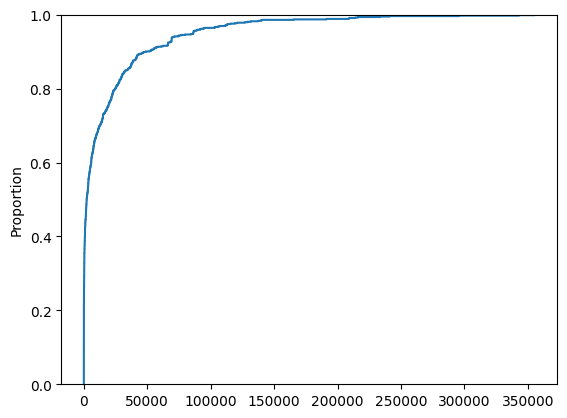

In [100]:
ax = sns.ecdfplot(data=app_frequencies_mean_in_s)

### ECDF of app frequencies (IQR)

This empirical cumulative density function showcases, for each interval IQR value, the proportion of apps that have a lower IQR interval time.

In [7]:
app_frequencies_iqr_in_s = {k: v*0.001 for k, v in app_frequencies_iqr.items()}

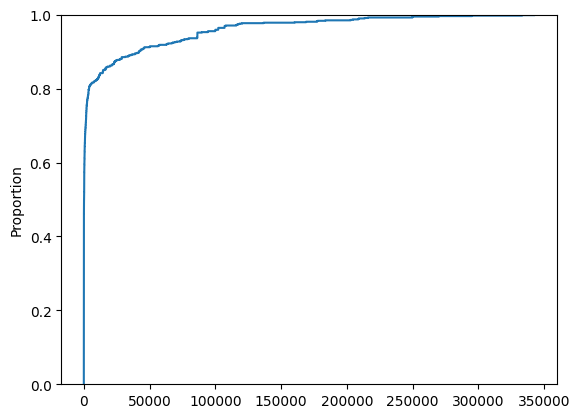

In [8]:
ax_iqr = sns.ecdfplot(data=app_frequencies_iqr_in_s)

## App-specific static analysis

### Randomly sampling app

In [ ]:
app_name = random.choice(list(app_frequencies_mean.keys()))

In [ ]:
app_name

In [ ]:
app_sample = sample[sample['AnonAppName'] == app_name]

### Number of files in app

In [ ]:
app_sample.AnonBlobName.nunique()

### Read/Write Ratio

In [ ]:
read_percentage = app_sample.Read.sum() * 100 / len(app_sample)
print('read =', read_percentage, 'write =', (100 - read_percentage))

### Distribution of intervals between files accesses

In [ ]:
invoc_interval = []
app_timestamps = app_sample['Timestamp'].values
for i in range(1, len(app_timestamps)):
    invoc_interval.append(app_timestamps[i] - app_timestamps[i-1])

In [ ]:
invoc_interval_in_s = {v: v*0.001 for v in invoc_interval}

### Kernel density estimation of distribution of invocation intervals

This kernel density estimation is a non-parametric technique (makes no assumptions about the shape of the data) used to smooth our finite data sample. For apps that have a particularly low amount of interval times, this KDE can produce a smooth distribution curve. 

### Static cold start simulation

In [ ]:
keep_alive = 50000

In [ ]:
cold_starts = 0
for i in range(1,len(app_sample)):
    if app_sample.iloc[i].Timestamp - app_sample.iloc[i-1].Timestamp > keep_alive:
        cold_starts += 1
        
cold_starts

## Picking representative apps

In [9]:
representative_apps = {}

To properly test our system, we sample applications on different slices of the IQR invocation interval distribution, notably, in between the 90th, 75th, 50th, 40th, 30th, 20th, and 10th percentiles. Most applications in the trace exclusively issue reads or writes, with some applicaitons issuing both. For each slice, we first partition applications into write-only and read-only groups, and then put applications with a read-to-write ratio of 20 to 80% in another group. Lastly, for each group in every slice, we pick an application with a reasonably high amount of IO requests and total bytes read/written. Our strategy ensures that we pick the most active applicaitons accross different invocation patterns. 

In addition, we sampled the applications with the highest amount of bytes read/written for stress-testing purposes.


### Analyses functions

For a given application, this function returns the number of files and data accesses (IO requests), the total amount of bytes read and written, and the percentage of reads.

In [10]:
def static_app_analyze(app_s):
    nr_of_files = app_s.AnonBlobName.nunique()
    nr_of_accesses = len(app_s)
    io_size = app_s['BlobBytes'].sum()
    percentage_read = app_s.Read.sum() * 100 / len(app_s)
    invoc_interval = []
    app_times = app_s['Timestamp'].values
    for i in range(1, len(app_times)):
        invoc_interval.append(app_times[i] - app_times[i-1])
    return nr_of_accesses, nr_of_files, io_size, percentage_read, invoc_interval

For a given dictionary of apps, this function finds the app with the largest number of IO requests whose read ratio falls in between a provided minimum and maximum threshold. We use this function to find apps within a slice of the IQR distribution.

In [11]:
def find_most_active(apps, min_thresh, max_thresh): 
    max_nr = 0
    max_app = "0"
    app = 0

    while app < len(apps):
        nr_a, nr_f, io_s, p_r, inv_int = static_app_analyze(sample[sample['AnonAppName'] == list(apps.keys())[app]])
        if not (p_r >= min_thresh and p_r <= max_thresh):
            app += 1
            continue
        if (max_nr < nr_a):
            max_nr = nr_a
            max_app = list(apps.keys())[app]
        app += 1
    
    return max_app

In [12]:
def find_apps(apps, min_thresh, max_thresh): 
    app = 0
    found = []

    while app < len(apps):
        print(app)
        to_analyze = sample[sample['AnonAppName'] == list(apps.keys())[app]]
        app += 1
        percentage_read = to_analyze.Read.sum() * 100 / len(to_analyze)
        if not (percentage_read >= min_thresh and percentage_read <= max_thresh):
            continue
        found.append(to_analyze)
    
    return found

For a given dictionary of apps, this function finds the app with the largest amount of IO bytes whose read ratio falls in between a provided minimum and maximum threshold. We use this function to find apps within a slice of the IQR distribution.

In [54]:
def find_most_active_io(apps, min_thresh, max_thresh): 
    max_nr = 0x
    max_app = "0"
    app = 0

    while app < len(apps):
        nr_a, nr_f, io_s, p_r, inv_int = static_app_analyze(sample[sample['AnonAppName'] == list(apps.keys())[app]])
        if not (p_r >= min_thresh and p_r <= max_thresh):
            app += 1
            continue
        if (max_nr < io_s):
            max_nr = io_s
            max_app = list(apps.keys())[app]
        app += 1
    
    return max_app

#### How to use the analyses functions to pick 3 apps within a slice

In [ ]:
apps_to_analyze = #name of dict containing apps

max_read = find_most_active(apps_to_analyze, 100, 100)
max_read_write = find_most_active(apps_to_analyze, 20, 80)
max_write = find_most_active(apps_to_analyze, 0, 0)

    
print(max_read)
nr_a, nr_f, io_s, p_r, inv_int = static_app_analyze(sample[sample['AnonAppName'] == max_read])
print("number of accesses = {}\nnumber of files = {}\ntotal io bytes = {}\npercentage of reads = {}\nIQR invocation interval = {}s"
      .format(nr_a,nr_f,io_s,p_r, apps_to_analyze[max_read]))

print(max_read_write)
nr_a, nr_f, io_s, p_r, inv_int = static_app_analyze(sample[sample['AnonAppName'] == max_read_write])
print("number of accesses = {}\nnumber of files = {}\ntotal io bytes = {}\npercentage of reads = {}\nIQR invocation interval = {}s"
      .format(nr_a,nr_f,io_s,p_r, apps_to_analyze[max_read_write]))

print(max_write)
nr_a, nr_f, io_s, p_r, inv_int = static_app_analyze(sample[sample['AnonAppName'] == max_write])
print("number of accesses = {}\nnumber of files = {}\ntotal io bytes = {}\npercentage of reads = {}\nIQR invocation interval = {}s"
      .format(nr_a,nr_f,io_s,p_r, apps_to_analyze[max_write]))

### Application with most amount of IO requests

In [142]:
sample.groupby('AnonAppName').size().sort_values()

AnonAppName
phcdbhdi          1
x24t9s74          1
lcy9t9ib          1
qy16k8ii          1
jhtq7yad          1
             ...   
q8act97c    2792944
xe6cd5yr    2813107
14pyyual    2824615
n0nh88df    2834698
0insggn2    8194253
Length: 856, dtype: int64

- **n0nh88df (100% reads)**
 - number of accesses = 2834698
 - number of files = 2
 - total io bytes = 64597432.0
 - IQR invocation interval = 0.044s
- **fmrflaav (50% reads)**
 - number of accesses = 482900
 - number of files = 1
 - total io bytes = 8209300.0
 - IQR invocation interval = 4.964s
- **0insggn2 (100% writes)**
 - number of accesses = 8194253
 - number of files = 4090978
 - total io bytes = 56216331219.0
 - percentage of reads = 0.0
 - IQR invocation interval = 0.081s 

In [1052]:
representative_apps["r_iorequests"] = sample[sample["AnonAppName"] == "n0nh88df"]
representative_apps["rw_iorequests"] = sample[sample["AnonAppName"] == "fmrflaav"]
representative_apps["w_iorequests"] = sample[sample["AnonAppName"] == "0insggn2"]

### Applications with the most amount of IO bytes 

In [136]:
sample.groupby('AnonAppName')['BlobBytes'].sum().sort_values()

AnonAppName
j5w0dtvm    0.000000e+00
mrnmbe9y    0.000000e+00
oc03x0xw    0.000000e+00
ogu1hyf6    0.000000e+00
ib9ov5pf    0.000000e+00
                ...     
15dp5na6    1.826102e+11
fe0gksjj    2.608031e+11
7onnbfho    4.477803e+11
7c51my6n    5.095099e+11
p0tgxvsc    5.116386e+11
Name: BlobBytes, Length: 856, dtype: float64

- **7c51my6n (100% reads)**
 - number of accesses = 43358
 - number of files = 42785
 - total io bytes = 509509878284.0
 - IQR invocation interval = 0.156s
- **p0tgxvsc (52% reads)**
 - number of accesses = 9999
 - number of files = 1568
 - total io bytes = 511638619511.0
 - IQR invocation interval = 1.025s
- **0insggn2 (100% writes)**
 - number of accesses = 8194253
 - number of files = 4090978
 - total io bytes = 56216331219.0
 - IQR invocation interval = 0.081s

In [19]:
representative_apps["r_iobytes"] = sample[sample["AnonAppName"] == "7c51my6n"]
representative_apps["rw_iobytes"] = sample[sample["AnonAppName"] == "p0tgxvsc"]
representative_apps["w_iobytes"] = sample[sample["AnonAppName"] == "0insggn2"]

In [958]:
serie = representative_apps["rw_iobytes"].set_index("Datetime").groupby(pd.Grouper(freq="60min")).size()

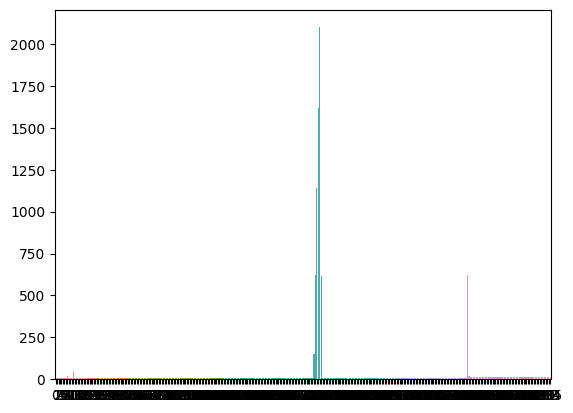

In [959]:
arr = []
arr.extend(range(len(serie.index)))
ax = sns.barplot(x=arr,y=serie.values, width=0.8)

### Representative apps

#### Most amount of IO requests
- **n0nh88df (100% reads)**
 - number of accesses = 2834698
 - number of files = 2
 - total io bytes = 64597432.0
 - IQR invocation interval = 0.044s
- **fmrflaav (50% reads)**
 - number of accesses = 482900
 - number of files = 1
 - total io bytes = 8209300.0
 - IQR invocation interval = 4.964s
- **0insggn2 (100% writes)**
 - number of accesses = 8194253
 - number of files = 4090978
 - total io bytes = 56216331219.0
 - percentage of reads = 0.0
 - IQR invocation interval = 0.081s 


#### Most amount of IO bytes
- **7c51my6n (100% reads)**
 - number of accesses = 43358
 - number of files = 42785
 - total io bytes = 509509878284.0
 - IQR invocation interval = 0.156s
- **p0tgxvsc (52% reads)**
 - number of accesses = 9999
 - number of files = 1568
 - total io bytes = 511638619511.0
 - IQR invocation interval = 1.025s
- **0insggn2 (100% writes)**
 - number of accesses = 8194253
 - number of files = 4090978
 - total io bytes = 56216331219.0
 - IQR invocation interval = 0.081s

#### below 1s

- **01qqaww4 (100% reads)**
 - number of accesses = 732673
 - number of files = 2
 - total io bytes = 18837010.0
 - IQR invocation interval = 0.088s
- **j2alqt8s (50% reads)**
 - number of accesses = 2466
 - number of files = 1986
 - total io bytes = 926194443.0
 - percentage of reads = 50.0
 - IQR invocation interval = 0.007s
- **0insggn2 (100% writes)**
 - number of accesses = 8194253
 - number of files = 4090978
 - total io bytes = 56216331219.0
 - IQR invocation interval = 0.081s
 
#### above 1s

- **7xjpt3h0 (100% reads)**
 - number of accesses = 86721
 - number of files = 86521
 - total io bytes = 1674522628.0
 - IQR invocation interval = 11.66225s
- **56t9rffh (52% reads)**
 - number of accesses = 228545
 - number of files = 1
 - total io bytes = 837341353.0
 - IQR invocation interval = 9.734s
- **kla1jqcy (100% writes)**
 - number of accesses = 149637
 - number of files = 149567
 - total io bytes = 216165102.0
 - IQR invocation interval = 28.868000000000002s
 
#### 30 - 35%

- **4fggcx6e (100% reads)**
 - number of accesses = 8377
 - number of files = 8373
 - total io bytes = 23463358.0
 - IQR invocation interval = 89.50025000000001s
- **ewf42d3t (45% reads)**
 - number of accesses = 7400
 - number of files = 1
 - total io bytes = 9575203697.0
 - IQR invocation interval = 179.2695s
- **u1q65cm8 (100% writes)**
 - number of accesses = 1329
 - number of files = 1329
 - total io bytes = 158030803.0
 - IQR invocation interval = 139.25675s
 
#### 40 - 45%

- **66wi1vut (100% reads)**
 - number of accesses = 2929
 - number of files = 2920
 - total io bytes = 113135667.0
 - IQR invocation interval = 875.11875s
- **4w6txiaf (60% reads)**
 - number of accesses = 5360
 - number of files = 1
 - total io bytes = 592091.0
 - percentage of reads = 60.80223880597015
 - IQR invocation interval = 562.982s
- **d4y7nqd7 (100% writes)**
 - number of accesses = 2871
 - number of files = 5
 - total io bytes = 129254506.0
 - IQR invocation interval = 580.268s

#### 45 - 50 %

- **012g40uf (100% reads)**
 - number of accesses = 109
 - number of files = 109
 - total io bytes = 1501027322.0
 - IQR invocation interval = 1706.8890000000001s
- **fhd060kw (100% reads)**
 - number of accesses = 448
 - number of files = 448
 - total io bytes = 9720059.0
 - IQR invocation interval = 1812.3915s
- **xye48b8s (50% reads)**
 - number of accesses = 1344
 - number of files = 28
 - total io bytes = 2469600.0
 - IQR invocation interval = 1799.194s
- **37v2syv5 (100% writes)**
 - number of accesses = 157
 - number of files = 157
 - total io bytes = 8934925.0
 - IQR invocation interval = 1935.3905s
 
#### 75 - 80 %
- **vlxwx3xg (100% reads)**
 - number of accesses = 1188
 - number of files = 1187
 - total io bytes = 3361907.0
 - IQR invocation interval = 3590.3265s
- **wvhbk430 (50% reads)**
 - number of accesses = 22
 - number of files = 22
 - total io bytes = 115443401.0
 - IQR invocation interval = 2144.686s
- **7pweh3lg (100% writes)**
 - number of accesses = 243
 - number of files = 243
 - total io bytes = 535343.0
 - IQR invocation interval = 2399.64475s

#### 90 -95 %
- **i0vdq3as (100% reads)**
 - number of accesses = 49
 - number of files = 3
 - total io bytes = 96432.0
 - IQR invocation interval = 79074.27275s
- **uwystwqh (55% reads)**
 - number of accesses = 36
 - number of files = 14
 - total io bytes = 60645592.0
 - IQR invocation interval = 86384.75200000001s
- **tmclsdfo (100% writes)**
 - number of accesses = 22
 - number of files = 3
 - total io bytes = 51635471.0
 - IQR invocation interval = 69219.371s

### Distribution of IQR intervals below 2000s (33 minutes)

- Picking apps beneath the 2k second range
    - pick apps that have a 100 ratio of read / 100 of writes and 50:50
    - Reasonably large enough number of IO requests
    - Apps across the following boundaries
        - 0 - 5%
        - 10-15%
        - 20-25%
        - 30-35%
        - 40-45%

In [54]:
app_frequencies_iqr_median = dict(filter(lambda elem: elem[1] <= 2000, app_frequencies_iqr_in_s.items()))

In [55]:
len(app_frequencies_iqr_median)

582

#### 0 - 50 % apps below the median

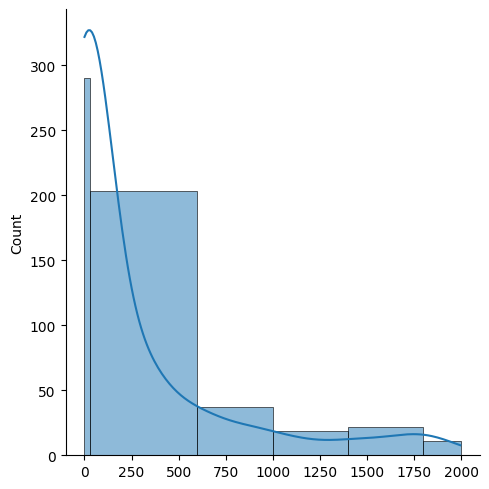

In [56]:
sns.displot(list(app_frequencies_iqr_median.values()), bins=[0, 30, 600, 1000, 1400, 1800, 2000], kde=True)

In [57]:
np.percentile(list(app_frequencies_iqr_median.values()), 50)

30.253

##### below 1s

In [961]:
app_frequencies_iqr_1 = dict(filter(lambda elem: elem[1] <= 1, app_frequencies_iqr_in_s.items()))

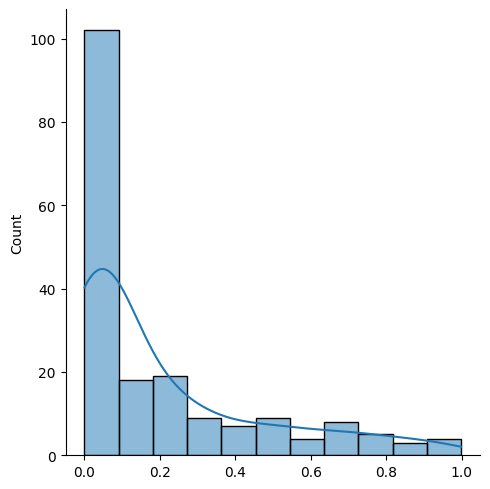

In [59]:
sns.displot(list(app_frequencies_iqr_1.values()), kde=True)

- **01qqaww4 (100% reads)**
 - number of accesses = 732673
 - number of files = 2
 - total io bytes = 18837010.0
 - IQR invocation interval = 0.088s
- **j2alqt8s (100% reads)**
 - number of accesses = 1379099
 - number of files = 2
 - total io bytes = 36598196.0
 - IQR invocation interval = 7.0s
- **0insggn2 (100% writes)**
 - number of accesses = 8194253
 - number of files = 4090978
 - total io bytes = 56216331219.0
 - IQR invocation interval = 0.081s


In [963]:
for i in app_frequencies_iqr_1.keys():
    if app_frequencies_iqr_1[i] == 0.007:
        print(i)
     

j2alqt8s
sbrre0s6
xnni291w


In [966]:
nr_a, nr_f, io_s, p_r, inv_int = static_app_analyze(sample[sample["AnonAppName"] == "j2alqt8s"])
print("number of accesses = {}\nnumber of files = {}\ntotal io bytes = {}\npercentage of reads = {}\nIQR invocation interval = {}ms"
      .format(nr_a,nr_f,io_s,p_r, iqr(inv_int)))

number of accesses = 1379099
number of files = 2
total io bytes = 36598196.0
percentage of reads = 100.0
IQR invocation interval = 7.0ms


In [13]:
representative_apps["r_below1s"] = sample[sample["AnonAppName"] == "01qqaww4"]
representative_apps["rw_below1s"] = sample[sample["AnonAppName"] == "j2alqt8s"]
representative_apps["w_below1s"] = sample[sample["AnonAppName"] == "0insggn2"]

In [1055]:
trace_01qqaww4 = representative_apps["r_below1s"]
trace_7xjpt3h0 = representative_apps["r_above1sbelow30"]
trace_66wi1vut = representative_apps["r_40_45"]
trace_0insggn2 = representative_apps["w_iorequests"]
trace_kla1jqcy = representative_apps["w_above1sbelow30"]
trace_u1q65cm8 = representative_apps["w_30_35"]
trace_7agnu66h = sample[sample["AnonAppName"] == "7agnu66h"]
trace_j03uywqk = sample[sample["AnonAppName"] == "j03uywqk"]
trace_xlxky5ax = representative_apps["rw_30_35"]

In [1159]:
app_sample = trace_01qqaww4

written_files = {}

blob_names = app_sample['AnonBlobName'].values
blob_bytes = app_sample['BlobBytes'].values
is_write = app_sample['Write'].values


for i in range(len(app_sample)):
    if is_write[i] == True:
        written_files[blob_names[i]] = blob_bytes[i]
    else:
        written_files[blob_names[i]] = max(not_yet_existing_files[blob_names[i]], 
                                                              blob_bytes[i])
        if blob_names[i] not in written_files.keys():
            if blob_names[i] not in not_yet_existing_files.keys():
                not_yet_existing_files[blob_names[i]] = blob_bytes[i]
            else:
                not_yet_existing_files[blob_names[i]] = max(not_yet_existing_files[blob_names[i]], 
                                                              blob_bytes[i])

In [1141]:
def static_analysis_baseline(trace, execution_time_of_regular_trace):
    cold_starts = 0
    warm_starts = 0

    timestamps = trace['Timestamp'].values

    for i in range(1,len(trace)):
        if timestamps[i] - timestamps[i-1] > 100:
            cold_starts += 1
        else:
            warm_starts += 1 
    
    
    
    access_time = (execution_time_of_regular_trace * 1000) / len(trace) 
    execution_time = 0
    
    for i in range(1,len(trace), 2):
        if timestamps[i] - timestamps[i-1] == 0:
            execution_time += access_time
        else:
            execution_time += 2 * access_time

    return cold_starts, warm_starts, execution_time * 0.001

In [1142]:
static_analysis_baseline(trace_01qqaww4, 1457)

(175712, 556960, 1328.3290540220853)

In [1144]:
static_analysis_baseline(trace_7xjpt3h0, 3003.3)

(54046, 32674, 2999.4212439911726)

In [1146]:
static_analysis_baseline(trace_66wi1vut, 240)

(2518, 410, 239.4264254011548)

In [1148]:
static_analysis_baseline(trace_0insggn2, 243)

(2850859, 5343393, 242.2143816077514)

In [1153]:
static_analysis_baseline(trace_kla1jqcy, 584)

(105510, 44126, 583.6019166373904)

In [1154]:
static_analysis_baseline(trace_u1q65cm8, 11)

(535, 793, 10.668924003009847)

In [1156]:
static_analysis_baseline(trace_7agnu66h, 103)

(3144, 2872, 101.35665614093627)

In [1157]:
static_analysis_baseline(trace_j03uywqk, 7)

(2127, 737, 6.71657940663196)

In [1158]:
static_analysis_baseline(trace_xlxky5ax, 53.5)

(4669, 1811, 48.20860978244002)

In [956]:
u1q65cm8nr_a, nr_f, io_s, p_r, inv_int = static_app_analyze(representative_apps["rw_below1s"])
print("number of accesses = {}\nnumber of files = {}\ntotal io bytes = {}\npercentage of reads = {}\nIQR invocation interval = {}ms"
      .format(nr_a,nr_f,io_s,p_r, iqr(inv_int)))

number of accesses = 1379099
number of files = 2
total io bytes = 36598196.0
percentage of reads = 100.0
IQR invocation interval = 7.0ms


In [889]:
print(np.sum(j2alqt8s_df_durations) * 1.66667e-11)

55.538074416610016


In [1032]:
representative_apps["r_below1s"]

,Timestamp,AnonRegion,AnonUserId,AnonAppName,AnonFunctionInvocationId,AnonBlobName,BlobType,AnonBlobETag,BlobBytes,Read,Write,Datetime
109,1606742519152,q2d,1209884869,01qqaww4,952444184,1wx5dgohq1kiwjum,BlockBlob/text/plain; charset=utf-8,fe17pjoa6k,28.0,True,False,2020-11-30 13:21:59.152
110,1606742523154,q2d,1209884869,01qqaww4,1705992660,1wx5dgohq1kiwjum,BlockBlob/text/plain; charset=utf-8,fe17pjoa6k,28.0,True,False,2020-11-30 13:22:03.154
111,1606742543224,q2d,1209884869,01qqaww4,1900250558,1wx5dgohq1kiwjum,BlockBlob/text/plain; charset=utf-8,fe17pjoa6k,28.0,True,False,2020-11-30 13:22:23.224
112,1606742582372,q2d,1209884869,01qqaww4,825529336,1wx5dgohq1kiwjum,BlockBlob/text/plain; charset=utf-8,fe17pjoa6k,28.0,True,False,2020-11-30 13:23:02.372
113,1606742582382,q2d,1209884869,01qqaww4,408568798,1wx5dgohq1kiwjum,BlockBlob/text/plain; charset=utf-8,fe17pjoa6k,28.0,True,False,2020-11-30 13:23:02.382
...,...,...,...,...,...,...,...,...,...,...,...,...
732777,1607297378000,q2d,1209884869,01qqaww4,1065084262,1wx5dgohq1kiwjum,BlockBlob/text/plain; charset=utf-8,g6h09hyxcg,28.0,True,False,2020-12-06 23:29:38.000
732778,1607297378000,q2d,1209884869,01qqaww4,1065084262,i5ms01i56ue2v7nt,BlockBlob/plain/text,thbhcbtago,10.0,True,False,2020-12-06 23:29:38.000
732779,1607297381225,q2d,1209884869,01qqaww4,1185125595,1wx5dgohq1kiwjum,BlockBlob/text/plain; charset=utf-8,g6h09hyxcg,28.0,True,False,2020-12-06 23:29:41.225
732780,1607297381229,q2d,1209884869,01qqaww4,1174170085,1wx5dgohq1kiwjum,BlockBlob/text/plain; charset=utf-8,g6h09hyxcg,28.0,True,False,2020-12-06 23:29:41.229


In [135]:
trace_sample = sample[sample["AnonAppName"] == "0insggn2"]
# r_below_sample[r_below_sample["Datetime"] < "2020-12-04 17:00:00"]

In [136]:
nr_a, nr_f, io_s, p_r, inv_int = static_app_analyze(trace_sample)

This sample's IQR is lower than the population because a third of the time spend by this app is idling  

In [137]:
iqr(inv_int)

81.0

In [138]:
serie = trace_sample.set_index("Datetime").groupby(pd.Grouper(freq="60min")).size()

In [139]:
serie.sort_values()

Datetime
2020-12-06 07:00:00     1234
2020-12-02 08:00:00     1700
2020-12-03 08:00:00     1866
2020-12-02 07:00:00     1974
2020-12-06 09:00:00     2034
                       ...  
2020-11-28 03:00:00    60962
2020-11-27 16:00:00    61637
2020-11-27 14:00:00    63499
2020-11-27 11:00:00    63808
2020-11-27 23:00:00    63895
Length: 336, dtype: int64

In [164]:
trace_sample = trace_sample[trace_sample["Datetime"] >= "2020-11-28 00:00:00"]
trace_sample = trace_sample[trace_sample["Datetime"] <= "2020-11-28 12:00:00"]

In [165]:
trace_sample

,Timestamp,AnonRegion,AnonUserId,AnonAppName,AnonFunctionInvocationId,AnonBlobName,BlobType,AnonBlobETag,BlobBytes,Read,Write,Datetime
7412715,1606521600036,dk4,2079865255,0insggn2,617006881,re2kjvb4bpvgs340,BlockBlob/,ekg8ninjh2,6555.0,False,True,2020-11-28 00:00:00.036
7412716,1606521600093,dk4,2079865255,0insggn2,617006881,re2kjvb4bpvgs340,BlockBlob/,5g4ykiucwi,6555.0,False,True,2020-11-28 00:00:00.093
7412717,1606521600120,dk4,2079865255,0insggn2,1055607069,ub8vvcrodcc1swgs,BlockBlob/,c24qw9tfp3,8.0,False,True,2020-11-28 00:00:00.120
7412718,1606521600169,dk4,2079865255,0insggn2,1055607069,ub8vvcrodcc1swgs,BlockBlob/,g3yf4j877x,8.0,False,True,2020-11-28 00:00:00.169
7412719,1606521600218,dk4,2079865255,0insggn2,506188740,chd5fvhhxpq1bicw,BlockBlob/,p635id0oho,542.0,False,True,2020-11-28 00:00:00.218
...,...,...,...,...,...,...,...,...,...,...,...,...
7868256,1606564799710,dk4,2079865255,0insggn2,61440611,wcbhr3xnr4o6s94i,BlockBlob/,06h3l805hi,18834.0,False,True,2020-11-28 11:59:59.710
7868257,1606564799758,dk4,2079865255,0insggn2,2069107222,b4ggtfjvoff6ck2d,BlockBlob/,lwjwdnbg4d,573.0,False,True,2020-11-28 11:59:59.758
7868258,1606564799808,dk4,2079865255,0insggn2,2069107222,b4ggtfjvoff6ck2d,BlockBlob/,h9bgmchath,573.0,False,True,2020-11-28 11:59:59.808
7868259,1606564799950,dk4,2079865255,0insggn2,1193130862,gmeio9wm4u5x25ub,BlockBlob/,6fiqjtok98,32225.0,False,True,2020-11-28 11:59:59.950


In [444]:
r_below_sample.groupby("AnonBlobName").agg('sum')

/var/folders/62/smvlkkzn71g5jmqvhj23jn_w0000gn/T/ipykernel_30532/3394489875.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  r_below_sample.groupby("AnonBlobName").agg('sum')


,Timestamp,AnonUserId,AnonFunctionInvocationId,BlobBytes,Read,Write
AnonBlobName,,,,,,
1wx5dgohq1kiwjum,7305661011470052,5500136614474,4890477777837,127288.0,4546,0
i5ms01i56ue2v7nt,7305661011510267,5500136614474,4890477777837,45460.0,4546,0


In [166]:
trace_sample.drop("Datetime",axis=1).to_csv("12hour-traces/0insggn2-12hour.csv", index=False)

In [9]:
sample[sample["AnonAppName"] == "0insggn2"].drop("Datetime", axis=1).to_csv("0insggn2.csv", index=False)

In [153]:
a=0
b=24

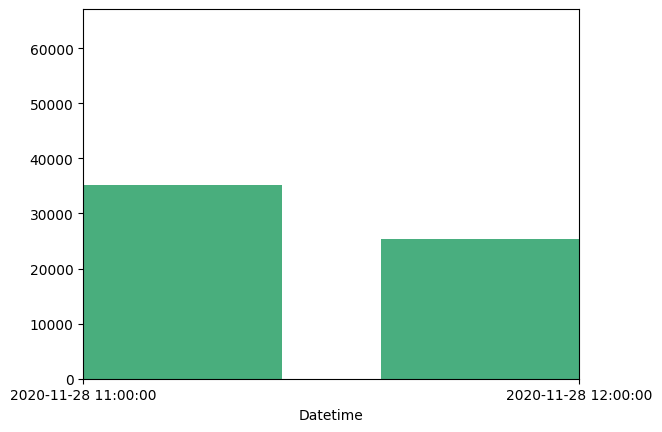

In [159]:
arr = []
arr.extend(range(len(serie.index)))
ax = sns.barplot(x=serie.index,y=serie.values, width=0.8)
ax.set_xlim(131,132)
a+=24
b+=24

In [46]:
lessthan = r_below_sample[r_below_sample["Datetime"] >= "2020-12-02 05:00:00"]

In [48]:
lessthan[lessthan["Datetime"] <= "2020-12-02 17:00:00"]

,Timestamp,AnonRegion,AnonUserId,AnonAppName,AnonFunctionInvocationId,AnonBlobName,BlobType,AnonBlobETag,BlobBytes,Read,Write,Datetime
346144,1606885200210,q2d,1209884869,01qqaww4,89770604,1wx5dgohq1kiwjum,BlockBlob/text/plain; charset=utf-8,dcb5xmdwnl,28.0,True,False,2020-12-02 05:00:00.210
346145,1606885200214,q2d,1209884869,01qqaww4,478083809,1wx5dgohq1kiwjum,BlockBlob/text/plain; charset=utf-8,dcb5xmdwnl,28.0,True,False,2020-12-02 05:00:00.214
346146,1606885200214,q2d,1209884869,01qqaww4,1001748105,1wx5dgohq1kiwjum,BlockBlob/text/plain; charset=utf-8,dcb5xmdwnl,28.0,True,False,2020-12-02 05:00:00.214
346147,1606885200219,q2d,1209884869,01qqaww4,135539780,1wx5dgohq1kiwjum,BlockBlob/text/plain; charset=utf-8,dcb5xmdwnl,28.0,True,False,2020-12-02 05:00:00.219
346148,1606885200223,q2d,1209884869,01qqaww4,915405008,1wx5dgohq1kiwjum,BlockBlob/text/plain; charset=utf-8,dcb5xmdwnl,28.0,True,False,2020-12-02 05:00:00.223
...,...,...,...,...,...,...,...,...,...,...,...,...
426660,1606928393307,q2d,1209884869,01qqaww4,1915243015,1wx5dgohq1kiwjum,BlockBlob/text/plain; charset=utf-8,feqva0xqqk,28.0,True,False,2020-12-02 16:59:53.307
426661,1606928393309,q2d,1209884869,01qqaww4,416351632,1wx5dgohq1kiwjum,BlockBlob/text/plain; charset=utf-8,feqva0xqqk,28.0,True,False,2020-12-02 16:59:53.309
426662,1606928393315,q2d,1209884869,01qqaww4,339502694,1wx5dgohq1kiwjum,BlockBlob/text/plain; charset=utf-8,feqva0xqqk,28.0,True,False,2020-12-02 16:59:53.315
426663,1606928394258,q2d,1209884869,01qqaww4,734013858,1wx5dgohq1kiwjum,BlockBlob/text/plain; charset=utf-8,feqva0xqqk,28.0,True,False,2020-12-02 16:59:54.258


In [73]:
sample.drop("Datetime", axis=1).to_csv("12hour-traces/7xjpt3h0-12hour.csv", index=False)

In [329]:
burst_trace = lessthan[lessthan["Datetime"] <= "2020-11-29 20:30:00"].Datetime

In [330]:
for i in burst_trace:
    print(i)

2020-11-29 19:30:20.237000
2020-11-29 19:30:20.242000
2020-11-29 19:30:20.246000
2020-11-29 19:30:20.246000
2020-11-29 19:30:21.005000
2020-11-29 19:30:21.005000
2020-11-29 19:30:21.008000
2020-11-29 19:30:21.009000
2020-11-29 19:30:21.311000
2020-11-29 19:30:21.324000
2020-11-29 19:30:22.074000
2020-11-29 19:30:22.078000
2020-11-29 19:30:22.079000
2020-11-29 19:30:22.083000
2020-11-29 19:30:22.086000
2020-11-29 19:30:22.087000
2020-11-29 19:30:22.205000
2020-11-29 19:30:22.213000
2020-11-29 19:30:22.213000
2020-11-29 19:30:22.221000
2020-11-29 19:30:22.226000
2020-11-29 19:30:22.229000
2020-11-29 19:30:22.229000
2020-11-29 19:30:22.234000
2020-11-29 19:30:22.234000
2020-11-29 19:30:22.385000
2020-11-29 19:30:22.385000
2020-11-29 19:30:22.398000
2020-11-29 19:30:22.398000
2020-11-29 19:30:23.147000
2020-11-29 19:30:23.147000
2020-11-29 19:30:23.148000
2020-11-29 19:30:23.152000
2020-11-29 19:30:23.152000
2020-11-29 19:30:23.153000
2020-11-29 19:30:23.156000
2020-11-29 19:30:23.161000
2

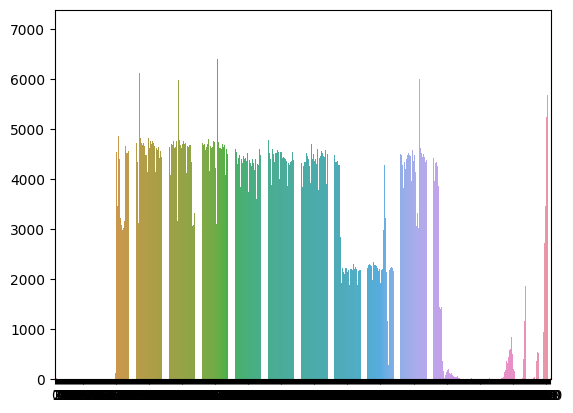

In [333]:
arr = []
arr.extend(range(len(serie.index)))
ax = sns.barplot(x=arr,y=serie.values)

In [247]:
max_index

167

In [36]:
nr_a, nr_f, io_s, p_r, inv_int = static_app_analyze(representative_apps["r_30_35"])
print("number of accesses = {}\nnumber of files = {}\ntotal io bytes = {}\npercentage of reads = {}\nIQR invocation interval = s"
      .format(nr_a,nr_f,io_s,p_r))

number of accesses = 8377
number of files = 8373
total io bytes = 23463358.0
percentage of reads = 100.0
IQR invocation interval = s


##### above 1s - below 30s

In [967]:
app_frequencies_iqr_30 = dict(filter(lambda elem: elem[1] > 1 and elem[1] <= 30, app_frequencies_iqr_in_s.items()))

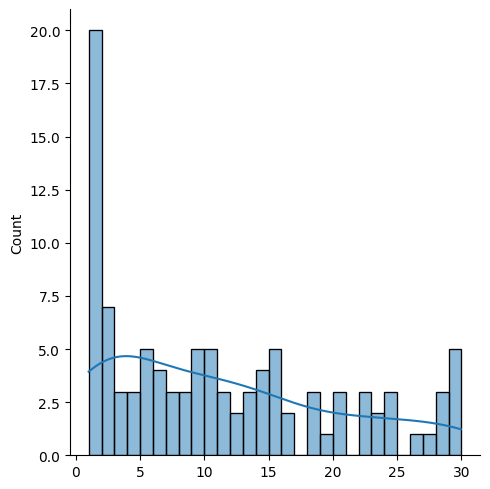

In [56]:
sns.displot(list(app_frequencies_iqr_30.values()), kde=True, binwidth=1)

In [968]:
len(app_frequencies_iqr_30)

102

In [ ]:
apps_to_analyze = app_frequencies_iqr_30

rw_apps = find_apps(apps_to_analyze, 20, 80)

In [50]:
for rw_app in rw_apps:
    nr_a, nr_f, io_s, p_r, inv_int = static_app_analyze(rw_app)
    if nr_f > 1 and nr_a > 1000:
        print(rw_app.AnonAppName.unique()[0])
        print("number of accesses = {}\nnumber of files = {}\ntotal io bytes = {}\npercentage of reads = {}\nIQR invocation interval = {}s"
              .format(nr_a,nr_f,io_s,p_r, apps_to_analyze[rw_app.AnonAppName.unique()[0]]))
        print("\n")

NameError: name 'rw_apps' is not defined

- 15dp5na6 (100% reads)
 - number of accesses = 39405
 - number of files = 31713
 - total io bytes = 182610241355.0
 - IQR invocation interval = 18.549500000000002s
- **7xjpt3h0 (100% reads)**
 - number of accesses = 86721
 - number of files = 86521
 - total io bytes = 1674522628.0
 - IQR invocation interval = 11.66225s
- **56t9rffh (52% reads)**
 - number of accesses = 228545
 - number of files = 1
 - total io bytes = 837341353.0
 - IQR invocation interval = 9.734s
- 5ianohq6 (50% reads)
 - number of accesses = 72492
 - number of files = 1
 - total io bytes = 2392236.0
 - IQR invocation interval = 29.964000000000002s
- 6md42mp2 (66% reads >1 file)
 - number of accesses = 21
 - number of files = 6
 - total io bytes = 8135792.0
 - IQR invocation interval = 19.5385s
- **kla1jqcy (100% writes)**
 - number of accesses = 149637
 - number of files = 149567
 - total io bytes = 216165102.0
 - IQR invocation interval = 28.868000000000002s

In [1053]:
representative_apps["r_above1sbelow30"] = sample[sample["AnonAppName"] == "7xjpt3h0"]
representative_apps["rw_above1sbelow30"] = sample[sample["AnonAppName"] == "j03uywqk"]
representative_apps["w_above1sbelow30"] = sample[sample["AnonAppName"] == "kla1jqcy"]

In [1026]:
representative_apps["r_above1sbelow30"].drop("Datetime", axis=1).to_csv("representative-apps/7xjpt3h0.csv",index=False)

In [145]:
candidate = sample[sample["AnonAppName"] == "xlxky5ax"]

In [124]:
serie = candidate.set_index("Datetime").groupby(pd.Grouper(freq="60min")).size()

In [87]:
serie

Datetime
2020-11-23 07:00:00    11
2020-11-23 08:00:00    11
2020-11-23 09:00:00    11
2020-11-23 10:00:00    22
2020-11-23 11:00:00    11
                       ..
2020-11-29 19:00:00     0
2020-11-29 20:00:00    26
2020-11-29 21:00:00    22
2020-11-29 22:00:00     8
2020-11-29 23:00:00     8
Freq: 60T, Length: 161, dtype: int64

In [1098]:
candidate.drop("Datetime",axis=1).to_csv("representative-apps/7agnu66h_sample.csv",index=False)

In [1009]:
candidate.sum()

/var/folders/62/smvlkkzn71g5jmqvhj23jn_w0000gn/T/ipykernel_30532/3280645103.py:1: FutureWarning: The default value of numeric_only in DataFrame.sum is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  candidate.sum()


Timestamp                                                    6168010526484866
AnonRegion                  ayiayiayiayiayiayiayiayiayiayiayiayiayiayiayia...
AnonUserId                                                      4858055190637
AnonAppName                 7agnu66h7agnu66h7agnu66h7agnu66h7agnu66h7agnu6...
AnonFunctionInvocationId                                        4186106776019
AnonBlobName                3e3eiayroqqu4gpttij22e0scmyg4k1dtij22e0scmyg4k...
BlobType                    BlockBlob/application/octet-streamBlockBlob/ap...
AnonBlobETag                n3ymbdhmbhi7krqsm0c3i7krqsm0c3ebj54whf7ftvqkqj...
BlobBytes                                                        1145276613.0
Read                                                                      840
Write                                                                    2999
dtype: object

In [999]:
serie = candidate.set_index("Datetime").groupby(pd.Grouper(freq="60min")).size()

In [1002]:
n1,n2,n3,n4,inv_int = static_app_analyze(candidate)

In [1015]:
candidate['BlobBytes'] = candidate['BlobBytes'].replace(0,1)

/var/folders/62/smvlkkzn71g5jmqvhj23jn_w0000gn/T/ipykernel_30532/1026659412.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  candidate['BlobBytes'] = candidate['BlobBytes'].replace(0,1)


In [21]:
candidate.drop("Datetime", axis=1).to_csv("12hour-traces/kla1jqcy-12hour.csv",index=False)

In [38]:
candidate

,Timestamp,AnonRegion,AnonUserId,AnonAppName,AnonFunctionInvocationId,AnonBlobName,BlobType,AnonBlobETag,BlobBytes,Read,Write,Datetime
16411784,1606089655639,1et,1558746109,66wi1vut,214479356,9mfao9y4sl08p3u7,BlockBlob/application/octet-stream,8pgdcow8c4,0.0,True,False,2020-11-23 00:00:55.639
16411785,1606089677066,1et,1558746109,66wi1vut,340161134,6lt2iaw0vvyq7ii3,BlockBlob/application/octet-stream,xl1ljkq6u9,0.0,True,False,2020-11-23 00:01:17.066
16411786,1606090552285,1et,1558746109,66wi1vut,304428891,061auj4d5vlty08v,BlockBlob/application/octet-stream,a2wkux5kfg,0.0,True,False,2020-11-23 00:15:52.285
16411787,1606090580843,1et,1558746109,66wi1vut,9093751,yk8vcdbmfonl72qf,BlockBlob/application/octet-stream,tbj7c4pejk,0.0,True,False,2020-11-23 00:16:20.843
16411788,1606091477233,1et,1558746109,66wi1vut,11610701,4r2900ynb5ecl326,BlockBlob/application/octet-stream,wjpqtfj2w6,0.0,True,False,2020-11-23 00:31:17.233
...,...,...,...,...,...,...,...,...,...,...,...,...
16414708,1607296561810,1et,1558746109,66wi1vut,54601502,j64f1y3qdpjgr16k,BlockBlob/application/octet-stream,guaafp0nhj,0.0,True,False,2020-12-06 23:16:01.810
16414709,1607297452737,1et,1558746109,66wi1vut,1807868141,qotym6fy4ocvlrjx,BlockBlob/application/octet-stream,26xncjugc4,0.0,True,False,2020-12-06 23:30:52.737
16414710,1607297464563,1et,1558746109,66wi1vut,1210715102,gupp89h65583j5gc,BlockBlob/application/octet-stream,ucxagpdfev,0.0,True,False,2020-12-06 23:31:04.563
16414711,1607298353839,1et,1558746109,66wi1vut,1863290108,756dk4xjg4luqaoo,BlockBlob/application/octet-stream,9o6w3qnws9,0.0,True,False,2020-12-06 23:45:53.839


In [22]:
candidate

,Timestamp,AnonRegion,AnonUserId,AnonAppName,AnonFunctionInvocationId,AnonBlobName,BlobType,AnonBlobETag,BlobBytes,Read,Write,Datetime
28274253,1606449600119,ayi,1594628998,kla1jqcy,206731720,af9eantdarncemd6,BlockBlob/,plm34p6d1l,1443.0,False,True,2020-11-27 04:00:00.119
28274254,1606449600533,ayi,1594628998,kla1jqcy,23024170,2y25qvip4n3qwrs5,BlockBlob/,ftifsa7hmi,1446.0,False,True,2020-11-27 04:00:00.533
28274255,1606449600642,ayi,1594628998,kla1jqcy,265054510,cdvc1w7srlaq98it,BlockBlob/,na3obphlm0,1455.0,False,True,2020-11-27 04:00:00.642
28274256,1606449600754,ayi,1594628998,kla1jqcy,1419620973,nr67jci2ubppq0fd,BlockBlob/,goei4tcx9n,1453.0,False,True,2020-11-27 04:00:00.754
28274257,1606449601035,ayi,1594628998,kla1jqcy,1804537285,isknmt7i03u3r5xi,BlockBlob/,1gucgl4kdt,1441.0,False,True,2020-11-27 04:00:01.035
...,...,...,...,...,...,...,...,...,...,...,...,...
28279893,1606492773385,ayi,1594628998,kla1jqcy,595554501,tm4nhfoiftqlog9r,BlockBlob/,chk8b4h236,1447.0,False,True,2020-11-27 15:59:33.385
28279894,1606492773409,ayi,1594628998,kla1jqcy,1124811606,w6ep4l7yc793nty4,BlockBlob/,qrd70wqe3u,1445.0,False,True,2020-11-27 15:59:33.409
28279895,1606492773818,ayi,1594628998,kla1jqcy,1081946334,0m1efcdhhbd8qxk5,BlockBlob/,010bgd9ca5,1447.0,False,True,2020-11-27 15:59:33.818
28279896,1606492773834,ayi,1594628998,kla1jqcy,946251380,2i407e9jgkvh7uqu,BlockBlob/,ea5yaoks88,1443.0,False,True,2020-11-27 15:59:33.834


(284.0, 285.0)

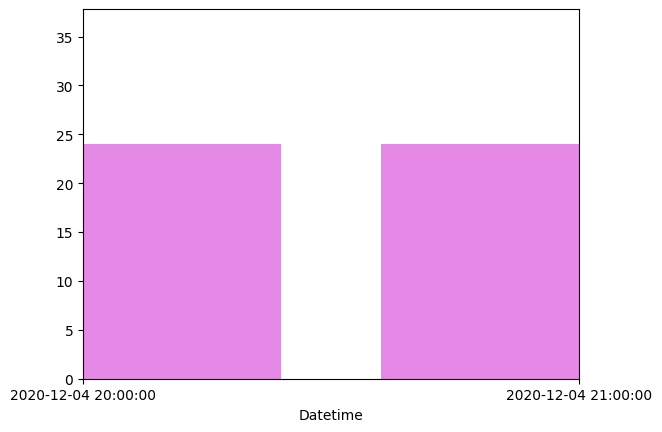

In [142]:
arr = []
arr.extend(range(len(serie.index)))
ax = sns.barplot(x=serie.index,y=serie.values)
ax.set_xlim(284,285)

In [146]:
candidate = candidate[candidate["Datetime"] >= "2020-12-04 09:00:00"]
candidate = candidate[candidate["Datetime"] <= "2020-12-04 21:00:00"]

In [147]:
candidate

,Timestamp,AnonRegion,AnonUserId,AnonAppName,AnonFunctionInvocationId,AnonBlobName,BlobType,AnonBlobETag,BlobBytes,Read,Write,Datetime
42628198,1607074050945,ayi,1381175665,xlxky5ax,1288526356,uojdwdeci0gxygf0,BlockBlob/,3csnl6tit9,112540.0,False,True,2020-12-04 09:27:30.945
42628199,1607074054391,ayi,1381175665,xlxky5ax,635202941,55fjm5h7uem5udjb,BlockBlob/,y3p44gmtau,160760.0,False,True,2020-12-04 09:27:34.391
42628200,1607074054420,ayi,1381175665,xlxky5ax,635202941,uojdwdeci0gxygf0,BlockBlob/application/octet-stream,3csnl6tit9,112540.0,True,False,2020-12-04 09:27:34.420
42628201,1607074054711,ayi,1381175665,xlxky5ax,1935010536,55fjm5h7uem5udjb,BlockBlob/application/octet-stream,y3p44gmtau,160760.0,True,False,2020-12-04 09:27:34.711
42628202,1607074125603,ayi,1381175665,xlxky5ax,620351015,uojdwdeci0gxygf0,BlockBlob/application/octet-stream,wyihkqtik5,112540.0,False,True,2020-12-04 09:28:45.603
...,...,...,...,...,...,...,...,...,...,...,...,...
42628493,1607114417852,ayi,1381175665,xlxky5ax,426371373,55fjm5h7uem5udjb,BlockBlob/application/octet-stream,hwk5oq8tv3,338164.0,True,False,2020-12-04 20:40:17.852
42628494,1607115015974,ayi,1381175665,xlxky5ax,253669817,uojdwdeci0gxygf0,BlockBlob/application/octet-stream,y34q11ffwm,250678.0,False,True,2020-12-04 20:50:15.974
42628495,1607115018109,ayi,1381175665,xlxky5ax,589387260,uojdwdeci0gxygf0,BlockBlob/application/octet-stream,y34q11ffwm,250678.0,True,False,2020-12-04 20:50:18.109
42628496,1607115018109,ayi,1381175665,xlxky5ax,589387260,55fjm5h7uem5udjb,BlockBlob/application/octet-stream,90jfpgjsyb,340743.0,False,True,2020-12-04 20:50:18.109


In [70]:
nr_a, nr_f, io_s, p_r, inv_int = static_app_analyze(candidate)
print("number of accesses = {}\nnumber of files = {}\ntotal io bytes = {}\npercentage of reads = {}\nIQR invocation interval = {}ms"
      .format(nr_a,nr_f,io_s,p_r, iqr(inv_int)))

NameError: name 'static_app_analyze' is not defined

In [148]:
candidate.drop("Datetime", axis=1).to_csv("12hour-traces/xlxky5ax-12hour.csv",index=False)

In [625]:
serie = representative_apps["rw_above1sbelow30"].set_index("Datetime").groupby(pd.Grouper(freq="60min")).size()

In [633]:
serie

Datetime
2020-11-23 00:00:00    6
2020-11-23 01:00:00    6
2020-11-23 02:00:00    6
2020-11-23 03:00:00    6
2020-11-23 04:00:00    6
                      ..
2020-12-06 19:00:00    6
2020-12-06 20:00:00    6
2020-12-06 21:00:00    6
2020-12-06 22:00:00    6
2020-12-06 23:00:00    6
Freq: 60T, Length: 336, dtype: int64

In [629]:
n1, n2, n3 , n4 , inv_int = static_app_analyze(representative_apps["rw_above1sbelow30"])

In [630]:
iqr(inv_int)

12108.0

In [682]:
trace_sparse = representative_apps["rw_above1sbelow30"][representative_apps["rw_above1sbelow30"]["Datetime"] >= "2020-11-23 03:00:00"]

In [683]:
trace_sparse = trace_sparse[trace_sparse["Datetime"] <= "2020-11-23 04:00:00"]

In [669]:
serie = trace_sparse.set_index("Datetime").groupby(pd.Grouper(freq="5min")).size()

In [692]:
trace_sparse

,Timestamp,AnonRegion,AnonUserId,AnonAppName,AnonFunctionInvocationId,AnonBlobName,BlobType,AnonBlobETag,BlobBytes,Read,Write,Datetime
26441325,1606100416312,ayi,1381175665,j03uywqk,669880467,oh9n8vb0efiqtqnh,BlockBlob/,r9c2gicrtp,2615.0,False,True,2020-11-23 03:00:16.312
26441326,1606100421243,ayi,1381175665,j03uywqk,1199510278,oh9n8vb0efiqtqnh,BlockBlob/application/octet-stream,r9c2gicrtp,2615.0,True,False,2020-11-23 03:00:21.243
26441327,1606100421243,ayi,1381175665,j03uywqk,1199510278,2if1bpjijqc6v5o8,BlockBlob/,u2q1r85k95,2764.0,False,True,2020-11-23 03:00:21.243
26441328,1606100432648,ayi,1381175665,j03uywqk,31767362,2if1bpjijqc6v5o8,BlockBlob/application/octet-stream,u2q1r85k95,2764.0,True,False,2020-11-23 03:00:32.648
26441329,1606100763745,ayi,1381175665,j03uywqk,811996916,20snnbbok8g50qqg,BlockBlob/,im6wswldgq,2318.0,False,True,2020-11-23 03:55:03.745
26441330,1606100773369,ayi,1381175665,j03uywqk,581894378,20snnbbok8g50qqg,BlockBlob/application/octet-stream,im6wswldgq,2318.0,True,False,2020-11-23 03:55:13.369


In [688]:
trace_sparse.at[26441329,'Timestamp'] = 1606103703745 - (300000 * 10) + 60000

In [689]:
trace_sparse.at[26441330,'Timestamp'] = 1606103713369 - (300000 * 10) + 60000

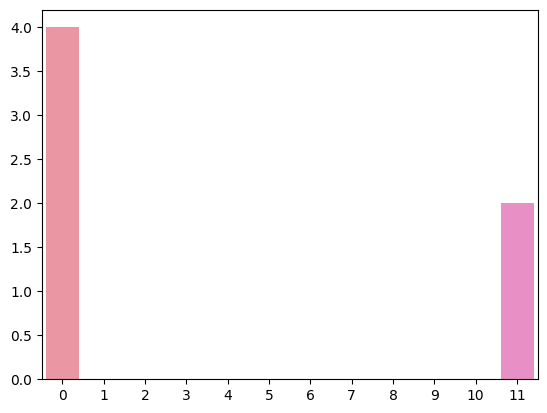

In [671]:
arr = []
arr.extend(range(len(serie.index)))
ax = sns.barplot(x=arr,y=serie.values)

In [563]:
trace_const_load = representative_apps["w_above1sbelow30"][representative_apps["w_above1sbelow30"]["Datetime"] >= "2020-11-23 03:00:00"]

In [564]:
trace_const_load[trace_const_load["Datetime"] <= "2020-11-23 04:00:00"].drop("Datetime", axis=1).to_csv("representative-apps/kla1jqcy_constload.csv", index=False)

In [553]:
serie = representative_apps["w_above1sbelow30"].set_index("Datetime").groupby(pd.Grouper(freq="60min")).size()

In [561]:
serie = trace_const_load.set_index("Datetime").groupby(pd.Grouper(freq="1min")).size()

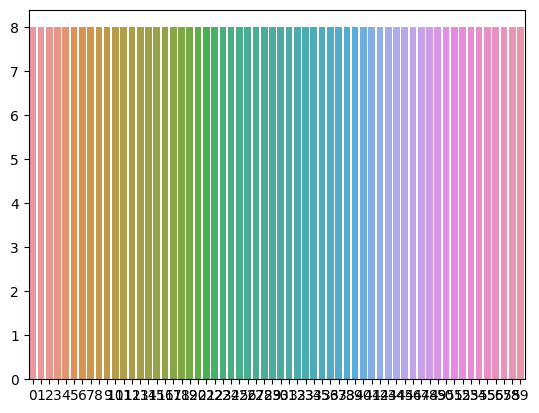

In [562]:
arr = []
arr.extend(range(len(serie.index)))
ax = sns.barplot(x=arr,y=serie.values)


In [543]:
n1, n2, n3 , n4 , inv_int = static_app_analyze(trace_const_load)

In [544]:
iqr(inv_int)

856.0

In [498]:
serie = representative_apps["r_above1sbelow30"].set_index("Datetime").groupby(pd.Grouper(freq="60min")).size()

In [506]:
serie[19]

334

In [504]:
trace_normal = representative_apps["r_above1sbelow30"]




[representative_apps["r_above1sbelow30"]["Datetime"] >=  "2020-11-23 19:00:00"]

In [510]:
trace_normal = trace_normal[trace_normal["Datetime"] <= "2020-11-23 20:00:00"]

In [515]:
n1, n2, n3 , n4 , inv_int = static_app_analyze(trace_normal)

In [516]:
iqr(inv_int)

12495.0

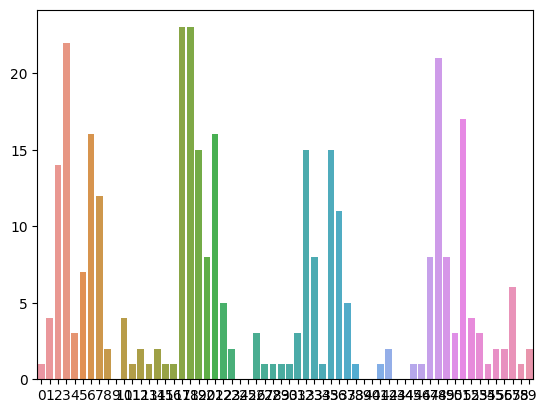

In [508]:
arr = []
arr.extend(range(len(serie.index)))
ax = sns.barplot(x=arr,y=serie.values)

#### 60 - 70 %

In [62]:
np.percentile(list(app_frequencies_iqr_median.values()), 60)

59.87199999999999

In [63]:
np.percentile(list(app_frequencies_iqr_median.values()), 70)

254.69594999999995

In [75]:
app_frequencies_iqr_250 = dict(filter(lambda elem: elem[1] >= 60 and elem[1] <= 250, app_frequencies_iqr_in_s.items()))

In [76]:
len(app_frequencies_iqr_250)

56

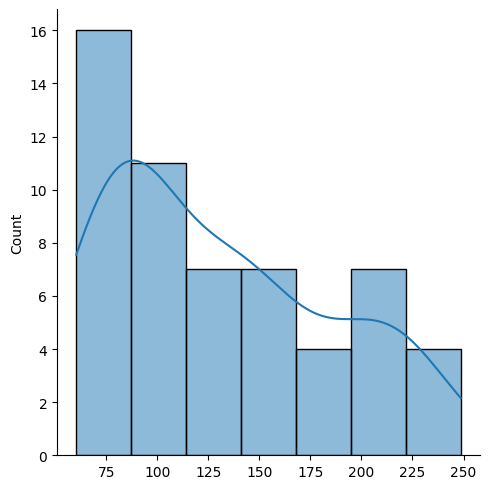

In [66]:
sns.displot(list(app_frequencies_iqr_250.values()), kde=True)

In [78]:
for rw_app in rw_apps:
    nr_a, nr_f, io_s, p_r, inv_int = static_app_analyze(rw_app)
    if nr_f > 1 and nr_a > 1000:
        print(rw_app.AnonAppName.unique()[0])
        print("number of accesses = {}\nnumber of files = {}\ntotal io bytes = {}\npercentage of reads = {}\nIQR invocation interval = {}s"
              .format(nr_a,nr_f,io_s,p_r, apps_to_analyze[rw_app.AnonAppName.unique()[0]]))
        print("\n")

d42uquij
number of accesses = 1191
number of files = 4
total io bytes = 10252861716.0
percentage of reads = 49.37027707808564
IQR invocation interval = 229.34s


xlxky5ax
number of accesses = 6481
number of files = 24
total io bytes = 1123733858.0
percentage of reads = 49.93056627063725
IQR invocation interval = 117.89275s




- **4fggcx6e (100% reads)**
 - number of accesses = 8377
 - number of files = 8373
 - total io bytes = 23463358.0
 - IQR invocation interval = 89.50025000000001s
- a3wk9k7c (100% reads)
 - number of accesses = 447
 - number of files = 443
 - total io bytes = 5593702.0
 - IQR invocation interval = 248.6635s
- t900wl4w (50% reads)
 - number of accesses = 18
 - number of files = 2
 - total io bytes = 181648.0
 - IQR invocation interval = 81.109s
- ewf42d3t (45% reads)
 - number of accesses = 7400
 - number of files = 1
 - total io bytes = 9575203697.0
 - IQR invocation interval = 179.2695s
- d42uquij (49% reads)
 - number of accesses = 1191
 - number of files = 4
 - total io bytes = 10252861716.0
 - IQR invocation interval = 229.34s
- 8ecleftb (100% writes)
 - number of accesses = 455
 - number of files = 455
 - total io bytes = 5815979.0
 - IQR invocation interval = 108.92750000000001s
- **u1q65cm8 (100% writes)**
 - number of accesses = 1329
 - number of files = 1329
 - total io bytes = 158030803.0
 - IQR invocation interval = 139.25675s

In [1054]:
representative_apps["r_30_35"] = sample[sample["AnonAppName"] == "4fggcx6e"]
representative_apps["rw_30_35"] = sample[sample["AnonAppName"] == "xlxky5ax"]
representative_apps["w_30_35"] = sample[sample["AnonAppName"] == "u1q65cm8"]

In [940]:
representative_apps["rw_30_35"].drop("Datetime", axis=1).to_csv("representative-apps/xlxky5ax.csv", index=False)

In [809]:
serie = representative_apps["rw_30_35"].set_index("Datetime").groupby(pd.Grouper(freq="60min")).size()

In [810]:
serie

Datetime
2020-11-23 00:00:00    21
2020-11-23 01:00:00    24
2020-11-23 02:00:00    24
2020-11-23 03:00:00    24
2020-11-23 04:00:00    24
                       ..
2020-12-06 19:00:00    24
2020-12-06 20:00:00    24
2020-12-06 21:00:00    24
2020-12-06 22:00:00    24
2020-12-06 23:00:00    24
Freq: 60T, Length: 336, dtype: int64

In [847]:
trace_pattern = representative_apps["rw_30_35"][representative_apps["rw_30_35"]["Datetime"] >= "2020-12-06 20:00:00"]
trace_pattern = trace_pattern[trace_pattern["Datetime"] <= "2020-12-06 21:00:00 "]

In [848]:
serie = trace_pattern.set_index("Datetime").groupby(pd.Grouper(freq="1min")).size()

In [849]:
n1,n2,n3,n4, inv_int = static_app_analyze(trace_pattern)

In [850]:
iqr(inv_int)

2204.5

In [875]:
trace_pattern["Datetime"] = pd.to_datetime(trace_pattern["Timestamp"], unit='ms')

In [877]:
trace_pattern.drop("Datetime", axis=1).to_csv("representative-apps/xlxky5ax_sparse_10.csv", index=False)

In [874]:
i = 1
multiplier = 0
for index, time in zip(trace_pattern.index, trace_pattern.Timestamp.values):
    trace_pattern.at[index,'Timestamp'] = time - multiplier * 480000
    if (i % 4 == 0):
        multiplier += 1
    i += 1

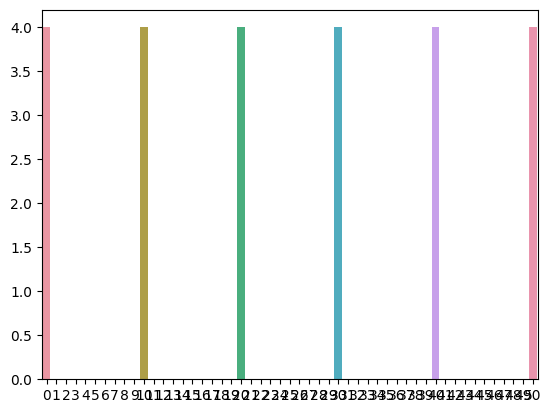

In [851]:
arr = []
arr.extend(range(len(serie.index)))
ax = sns.barplot(x=arr,y=serie.values)

In [883]:
serie = representative_apps["w_30_35"].set_index("Datetime").groupby(pd.Grouper(freq="60min")).size()

In [903]:
serie

Datetime
2020-11-23 07:00:00     4
2020-11-23 08:00:00     0
2020-11-23 09:00:00     6
2020-11-23 10:00:00     0
2020-11-23 11:00:00     6
                       ..
2020-12-06 18:00:00     2
2020-12-06 19:00:00    24
2020-12-06 20:00:00     4
2020-12-06 21:00:00     0
2020-12-06 22:00:00     8
Freq: 60T, Length: 328, dtype: int64

In [922]:
trace_unknown = representative_apps["w_30_35"][representative_apps["w_30_35"]["Datetime"] >= "2020-11-23 07:00:00"]

In [923]:
trace_unknown = trace_unknown[trace_unknown["Datetime"] <= "2020-11-23 08:00:00"]

In [931]:
trace_unknown.set_index("Datetime").groupby(pd.Grouper(freq="1min")).size()

Datetime
2020-11-23 07:15:00    2
2020-11-23 07:16:00    0
2020-11-23 07:17:00    0
2020-11-23 07:18:00    0
2020-11-23 07:19:00    0
2020-11-23 07:20:00    2
Freq: T, dtype: int64

In [927]:
trace_unknown.at[37924091, "Timestamp"] = 1606117555815 - 1500000
trace_unknown.at[37924092, "Timestamp"] = 1606117555830 - 1500000

In [930]:
trace_unknown["Datetime"] = pd.to_datetime(trace_unknown["Timestamp"], unit="ms")

In [932]:
trace_unknown.drop("Datetime", axis=1).to_csv("representative-apps/u1q65cm8_unknown.csv",index=False)

In [885]:
n1,n2,n3,n4, inv_int = static_app_analyze(representative_apps["w_30_35"])

In [886]:
iqr(inv_int)

139256.75

In [887]:
len(serie)

328

(0.0, 51.0)

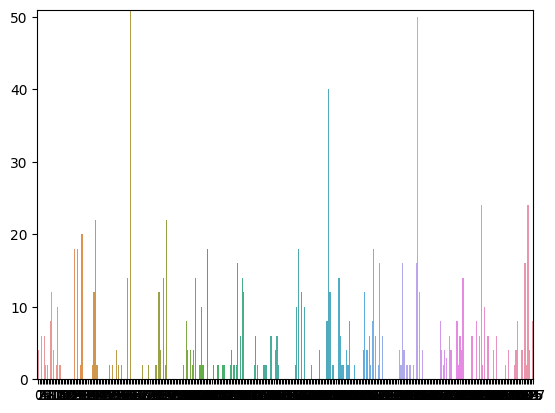

In [901]:
arr = []
arr.extend(range(len(serie.index)))
ax = sns.barplot(x=arr,y=serie.values)
ax.set_ylim(0,51)

In [895]:
xp_df_durations = [61179825382, 
                    258090227527, 
                    152710175634,
                    162004451204,
                    83931926157,
                    145381324664,
                    297998707148,
                    60003383206,
                    59999106462,
                    110690326655,
                    97218234409,
                    200467578055,
                    280321809796,
                    60001359902,
                    297998910255,
                    297998408696,
                    144326109845,
                    108978807144,
                    64701174346,
                    60005400518]

In [899]:
np.sum(xp_df_durations) * 1.66667e-11

50.066887583658236

#### 80 - 90 %

In [67]:
np.percentile(list(app_frequencies_iqr_median.values()), 80)

419.1724000000001

In [68]:
np.percentile(list(app_frequencies_iqr_median.values()), 90)

916.1987999999998

In [69]:
app_frequencies_iqr_80 = dict(filter(lambda elem: elem[1] >= 419 and elem[1] <= 917, app_frequencies_iqr_in_s.items()))

In [70]:
len(app_frequencies_iqr_80)

58

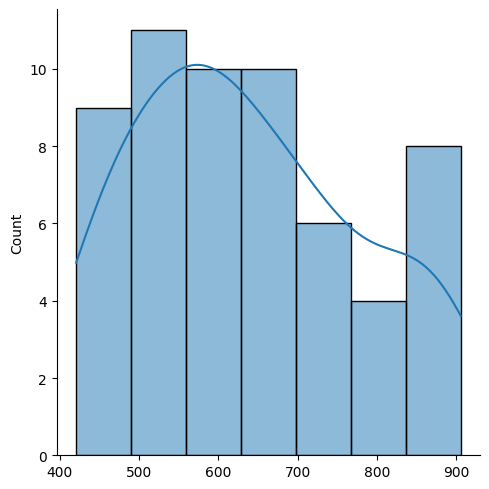

In [71]:
sns.displot(list(app_frequencies_iqr_80.values()), kde=True)

- 0brvghkm (100% reads)
 - number of accesses = 492
 - number of files = 1
 - total io bytes = 67846464.0
 - IQR invocation interval = 434.015s
- 7kuyx5lb (100% reads)
 - number of accesses = 1617
 - number of files = 1103
 - total io bytes = 4953032346.0
 - IQR invocation interval = 622.832s
- **66wi1vut (100% reads)**
 - number of accesses = 2929
 - number of files = 2920
 - total io bytes = 113135667.0
 - IQR invocation interval = 875.11875s
- 66wi1vut (100% reads)
 - number of accesses = 2929
 - number of files = 2920
 - total io bytes = 113135667.0
 - IQR invocation interval = 875.11875s
- 049oi3na (66% reads)
 - number of accesses = 4830
 - number of files = 1
 - total io bytes = 324038.0
 - IQR invocation interval = 553.296s
- **4w6txiaf (60% reads)**
 - number of accesses = 5360
 - number of files = 1
 - total io bytes = 592091.0
 - percentage of reads = 60.80223880597015
 - IQR invocation interval = 562.982s
- 5y08x017 (42% reads)
 - number of accesses = 26
 - number of files = 7
 - total io bytes = 527263183.0
 - IQR invocation interval = 673.471s
- rwahccu6 (100% writes)
 - number of accesses = 503
 - number of files = 503
 - total io bytes = 130717.0
 - IQR invocation interval = 420.4685s
- **d4y7nqd7 (100% writes)**
 - number of accesses = 2871
 - number of files = 5
 - total io bytes = 129254506.0
 - IQR invocation interval = 580.268s

In [1051]:
representative_apps["r_40_45"] = sample[sample["AnonAppName"] == "66wi1vut"]
representative_apps["rw_40_45"] = sample[sample["AnonAppName"] == "4w6txiaf"]
representative_apps["w_40_45"] = sample[sample["AnonAppName"] == "d4y7nqd7"]

In [945]:
representative_apps["r_40_45"]['BlobBytes']=representative_apps["r_40_45"]['BlobBytes'].replace(0,1)

In [952]:
representative_apps["r_40_45"].drop("Datetime", axis=1).to_csv("representative-apps/66wi1vut.csv", index=False)

In [700]:
serie = representative_apps["r_40_45"].set_index("Datetime").groupby(pd.Grouper(freq="60min")).size()

In [703]:
serie.unique

<bound method Series.unique of Datetime
2020-11-23 00:00:00    8
2020-11-23 01:00:00    8
2020-11-23 02:00:00    8
2020-11-23 03:00:00    8
2020-11-23 04:00:00    8
                      ..
2020-12-06 19:00:00    8
2020-12-06 20:00:00    8
2020-12-06 21:00:00    7
2020-12-06 22:00:00    8
2020-12-06 23:00:00    8
Freq: 60T, Length: 336, dtype: int64>

In [695]:
n1,n2,n3,n4, inv_int = static_app_analyze(representative_apps["r_40_45"])

In [696]:
iqr(inv_int)

875118.75

In [704]:
trace_sparse_r = representative_apps["r_40_45"][representative_apps["r_40_45"]["Datetime"] >= "2020-11-23 03:00:00"]

In [705]:
trace_sparse_r = trace_sparse_r[trace_sparse_r["Datetime"] <= "2020-11-23 04:00:00"]

In [711]:
serie = trace_sparse_r.set_index("Datetime").groupby(pd.Grouper(freq="15min")).size()

In [739]:
trace_sparse_r["Datetime"] = pd.to_datetime(trace_sparse_r["Timestamp"], unit='ms')

/var/folders/62/smvlkkzn71g5jmqvhj23jn_w0000gn/T/ipykernel_30532/3513299281.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trace_sparse_r["Datetime"] = pd.to_datetime(trace_sparse_r["Timestamp"], unit='ms')


In [754]:
trace_sparse_r

,Timestamp,AnonRegion,AnonUserId,AnonAppName,AnonFunctionInvocationId,AnonBlobName,BlobType,AnonBlobETag,BlobBytes,Read,Write,Datetime
16411808,1606100446604,1et,1558746109,66wi1vut,1668644690,6i9rl4couue3xtmm,BlockBlob/application/octet-stream,yjtgehrcnt,0.0,True,False,2020-11-23 03:00:46.604
16411809,1606100474925,1et,1558746109,66wi1vut,1849665691,jjnj7wi1xfmr5b3c,BlockBlob/application/octet-stream,rqtmlmsfgr,0.0,True,False,2020-11-23 03:01:14.925
16411810,1606100591878,1et,1558746109,66wi1vut,1313472676,j34tl457gofrvaxx,BlockBlob/application/octet-stream,3qao6iyfg8,0.0,True,False,2020-11-23 03:03:11.878
16411811,1606100591958,1et,1558746109,66wi1vut,1921751709,dfbbs23h8p70bpsi,BlockBlob/application/octet-stream,cuxfegwuga,0.0,True,False,2020-11-23 03:03:11.958
16411812,1606100695163,1et,1558746109,66wi1vut,36643072,a5aaeimj5d1jdjyg,BlockBlob/application/octet-stream,7llj0sukbv,0.0,True,False,2020-11-23 03:04:55.163
16411813,1606100709340,1et,1558746109,66wi1vut,1387618464,9feanw72g4bnogi3,BlockBlob/application/octet-stream,90hxiuud8y,0.0,True,False,2020-11-23 03:05:09.340
16411814,1606100830608,1et,1558746109,66wi1vut,832079717,1ct6vstksnyl9u5w,BlockBlob/application/octet-stream,pcrwutc0wa,0.0,True,False,2020-11-23 03:07:10.608
16411815,1606100890608,1et,1558746109,66wi1vut,1164849908,9lnjj462nyl33ak5,BlockBlob/application/octet-stream,uglbgxtgil,0.0,True,False,2020-11-23 03:08:10.608


In [741]:
trace_sparse_r.drop("Datetime", axis=1).to_csv("representative-apps/66wi1vut_sparse_15.csv", index=False)

In [716]:
trace_sparse_r.at[16411810 ,'Timestamp'] = 1606101371878 - 780000

In [717]:
trace_sparse_r.at[16411811 ,'Timestamp'] = 1606101371958 - 780000

In [727]:
trace_sparse_r.at[16411812 ,'Timestamp'] = 1606101475163 - 780000

In [728]:
trace_sparse_r.at[16411813 ,'Timestamp'] = 1606101489340 - 780000

In [738]:
trace_sparse_r.at[16411814 ,'Timestamp'] = 1606100890608 - 60000

In [731]:
trace_sparse_r.at[16411815 ,'Timestamp'] = 1606102390608 - 1500000

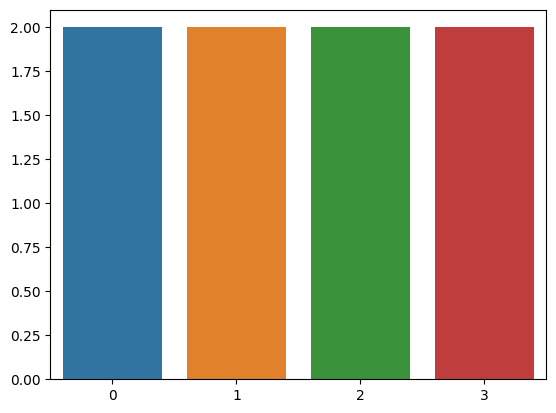

In [713]:
arr = []
arr.extend(range(len(serie.index)))
ax = sns.barplot(x=arr,y=serie.values)

#### 95 - 100 %

In [72]:
np.percentile(list(app_frequencies_iqr_median.values()), 95)

1491.1430999999993

In [73]:
np.percentile(list(app_frequencies_iqr_median.values()), 100)

1995.046

In [74]:
app_frequencies_iqr_100 = dict(filter(lambda elem: elem[1] >= 1491 and elem[1] <= 1996, app_frequencies_iqr_in_s.items()))

In [75]:
len(app_frequencies_iqr_100)

30

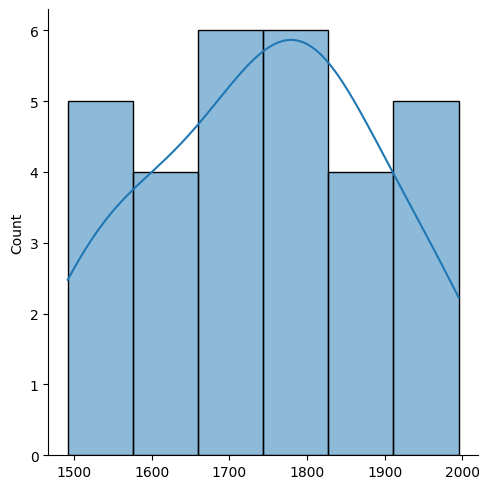

In [76]:
sns.displot(list(app_frequencies_iqr_100.values()), kde=True)

- **012g40uf (100% reads)**
 - number of accesses = 109
 - number of files = 109
 - total io bytes = 1501027322.0
 - IQR invocation interval = 1706.8890000000001s
- **fhd060kw (100% reads)**
 - number of accesses = 448
 - number of files = 448
 - total io bytes = 9720059.0
 - IQR invocation interval = 1812.3915s
- 2h9hxtw0 (100% reads)
 - number of accesses = 263
 - number of files = 23
 - total io bytes = 17293008.0
 - IQR invocation interval = 1923.64s
- **xye48b8s (50% reads)**
 - number of accesses = 1344
 - number of files = 28
 - total io bytes = 2469600.0
 - IQR invocation interval = 1799.194s
- **yaeaugfl (57% reads)**
 - number of accesses = 1522
 - number of files = 889
 - total io bytes = 761386.0
 - IQR invocation interval = 1776.94s
- 0s7w2e6h (100% writes)
 - number of accesses = 41
 - number of files = 41
 - total io bytes = 137606.0
 - IQR invocation interval = 1608.579s
- **37v2syv5 (100% writes)**
 - number of accesses = 157
 - number of files = 157
 - total io bytes = 8934925.0
 - IQR invocation interval = 1935.3905s

In [24]:
representative_apps["r_45_50"] = sample[sample["AnonAppName"] == "fhd060kw"]
representative_apps["rw_45_50"] = sample[sample["AnonAppName"] == "xye48b8s"]
representative_apps["w_45_50"] = sample[sample["AnonAppName"] == "37v2syv5"]

In [316]:
lessthan = representative_apps["w_iobytes"][representative_apps["w_iobytes"]["Datetime"] >= "2020-11-27 16:00:00"]

In [319]:
lessthan[lessthan["Datetime"] <= "2020-11-27 17:00:00"].drop("Datetime", axis=1).to_csv("representative-apps/0insggn2_peak_hour.csv",index=False)

In [310]:
representative_apps["w_iobytes"].set_index("Datetime").groupby(pd.Grouper(freq="60min")).agg('sum')

/var/folders/62/smvlkkzn71g5jmqvhj23jn_w0000gn/T/ipykernel_30532/333203316.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  representative_apps["w_iobytes"].set_index("Datetime").groupby(pd.Grouper(freq="60min")).agg('sum')


,Timestamp,AnonUserId,AnonFunctionInvocationId,BlobBytes,Read,Write
Datetime,,,,,,
2020-11-23 00:00:00,78303386282595998,101401750642270,52565682557012,312129644.0,0,48754
2020-11-23 01:00:00,80606697245008233,104384277417940,53907155188092,302100966.0,0,50188
2020-11-23 02:00:00,79807041462873580,103348504520950,53339806073774,324321574.0,0,49690
2020-11-23 03:00:00,74108766557485497,95969142596210,49697548630140,303035720.0,0,46142
2020-11-23 04:00:00,74124990764599485,95989941248760,49337883216890,312134874.0,0,46152
...,...,...,...,...,...,...
2020-12-06 19:00:00,14516985593681937,18785342983160,9752820662172,64138586.0,0,9032
2020-12-06 20:00:00,10006967400796846,12949241077630,6566265791544,43113690.0,0,6226
2020-12-06 21:00:00,8685796685123928,11239591838020,5887552488904,37463012.0,0,5404


In [189]:
n1, n2, n3, n4, invoc = static_app_analyze(lessthan[lessthan["Datetime"] > "2020-12-01 01:00:00"])

In [196]:
np.subtract(*np.percentile(invoc, [75, 25])) * 0.001

0.089

In [151]:
serie = representative_apps["w_iobytes"].set_index("Datetime").groupby(pd.Grouper(freq="60min")).size()

<AxesSubplot: xlabel='Datetime'>

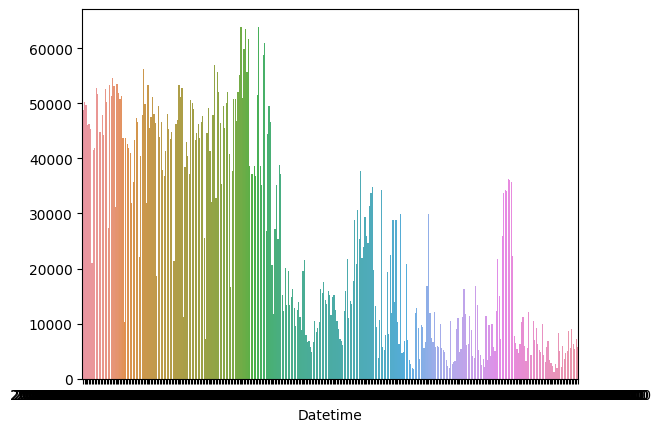

In [197]:
sns.barplot(x=serie.index, y=serie.values)

In [166]:
np.subtract(*np.percentile(serie.values, [75, 25]))

36153.0

In [170]:
(np.percentile(serie.values, 75) - np.percentile(serie.values, 25)) / 2

18076.5

In [161]:
for hour, request_size in zip(serie.index,serie.values):
    if 24000 < request_size  < 25000:
        print(hour)

2020-12-01 01:00:00


### 75th percentile (infrequent invocations)

In [125]:
np.percentile(list(app_frequencies_iqr_in_s.values()), 75)

2096.4235

In [126]:
np.percentile(list(app_frequencies_iqr_in_s.values()), 80)

3988.0828000000033

In [127]:
app_frequencies_iqr_75p = dict(filter(lambda elem: elem[1] >= 2000 and elem[1] <= 4000, app_frequencies_iqr_in_s.items()))

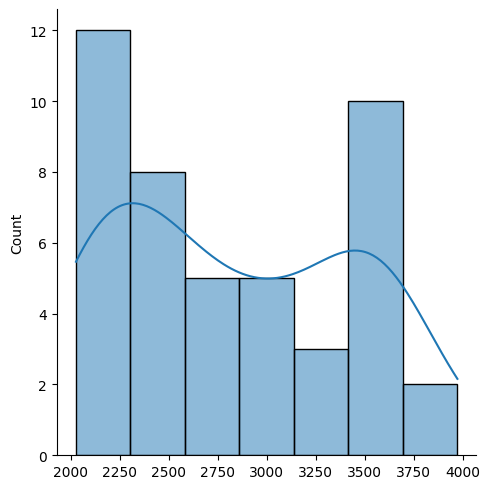

In [144]:
sns.displot(list(app_frequencies_iqr_75p.values()), kde=True)

- **vlxwx3xg (100% reads)**
 - number of accesses = 1188
 - number of files = 1187
 - total io bytes = 3361907.0
 - IQR invocation interval = 3590.3265s
- **wvhbk430 (50% reads)**
 - number of accesses = 22
 - number of files = 22
 - total io bytes = 115443401.0
 - IQR invocation interval = 2144.686s
- **7pweh3lg (100% writes)**
 - number of accesses = 243
 - number of files = 243
 - total io bytes = 535343.0
 - IQR invocation interval = 2399.64475s

In [25]:
representative_apps["r_75"] = sample[sample["AnonAppName"] == "vlxwx3xg"]
representative_apps["rw_75"] = sample[sample["AnonAppName"] == "wvhbk430"]
representative_apps["w_75"] = sample[sample["AnonAppName"] == "7pweh3lg"]

### 90th percentile (extremely infrequent)

In [129]:
np.percentile(list(app_frequencies_iqr_in_s.values()), 90)

42024.884300000005

In [130]:
np.percentile(list(app_frequencies_iqr_in_s.values()), 95)

86395.941325

In [131]:
app_frequencies_iqr_90p = dict(filter(lambda elem: elem[1] >= 42000 and elem[1] <= 86400, app_frequencies_iqr_in_s.items()))

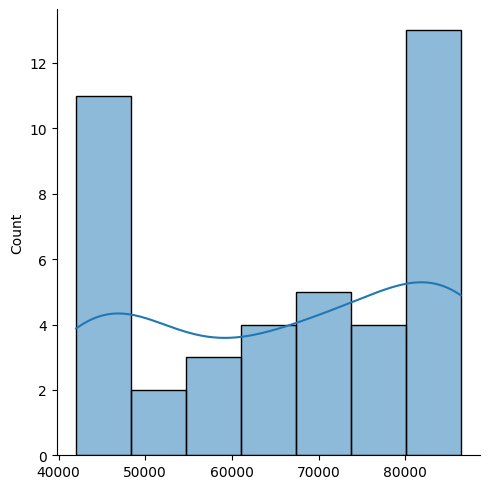

In [145]:
sns.displot(list(app_frequencies_iqr_90p.values()), kde=True)

- **i0vdq3as (100% reads)**
 - number of accesses = 49
 - number of files = 3
 - total io bytes = 96432.0
 - IQR invocation interval = 79074.27275s
- **uwystwqh (55% reads)**
 - number of accesses = 36
 - number of files = 14
 - total io bytes = 60645592.0
 - IQR invocation interval = 86384.75200000001s
- **tmclsdfo (100% writes)**
 - number of accesses = 22
 - number of files = 3
 - total io bytes = 51635471.0
 - IQR invocation interval = 69219.371s


In [26]:
representative_apps["r_90"] = sample[sample["AnonAppName"] == "i0vdq3as"]
representative_apps["rw_90"] = sample[sample["AnonAppName"] == "uwystwqh"]
representative_apps["w_90"] = sample[sample["AnonAppName"] == "tmclsdfo"]

## Exporting representative apps

In [27]:
for app_name in representative_apps.keys():
    representative_apps[app_name].drop(columns=['Datetime']).to_csv("representative-apps/{}.csv".format(app_name), index=False)

## Exporting missing files for apps

In [118]:
for app_name in representative_apps.keys():
    repr_app = representative_apps[app_name]
    
    written_files = {}
    not_yet_existing_files = {}
    reads_to_non_existing = 0

    blob_names = repr_app['AnonBlobName'].values
    blob_bytes = repr_app['BlobBytes'].values
    is_write = repr_app['Write'].values


    for i in range(len(repr_app)):
        if is_write[i] == True:
            written_files[blob_names[i]] = blob_bytes[i]
        else:
            if blob_names[i] not in written_files.keys():
                if blob_names[i] not in not_yet_existing_files.keys():
                    not_yet_existing_files[blob_names[i]] = blob_bytes[i]
                else:
                    not_yet_existing_files[blob_names[i]] = max(not_yet_existing_files[blob_names[i]], 
                                                                  blob_bytes[i])
    with open("reprapps-missing-files/{}_missing_files.txt".format(app_name), "w+") as file:
        for key in not_yet_existing_files.keys():
            file.write("{} {}\n".format(key, not_yet_existing_files[key]))

# Trace general statistics

## Total size of files in trace

In [161]:
blobs = {}

blob_names = df['AnonBlobName'].values
blob_bytes = df['BlobBytes'].values

for i in range(len(df)):
    if blob_names[i] not in blobs:
        blobs[blob_names[i]] = blob_bytes[i]
    else:
        blobs[blob_names[i]] = max(blobs[blob_names[i]], blob_bytes[i])

In [162]:
total_size=0.0

for val in blobs.values():
    if val > 0: 
        total_size+=val

In [163]:
print(total_size * 1e-12, "Terabytes")

1.823037843458 Terabytes


## Number of users

In [164]:
df.AnonUserId.value_counts()

1209884869    19327498
2079865255     8194253
1144001589     2239163
1807130425     1975009
1697074040     1971303
                ...   
871735667            1
2035805881           1
665613106            1
1952507721           1
2033915113           1
Name: AnonUserId, Length: 509, dtype: int64

## Number of accesses per user

<AxesSubplot: ylabel='AnonUserId'>

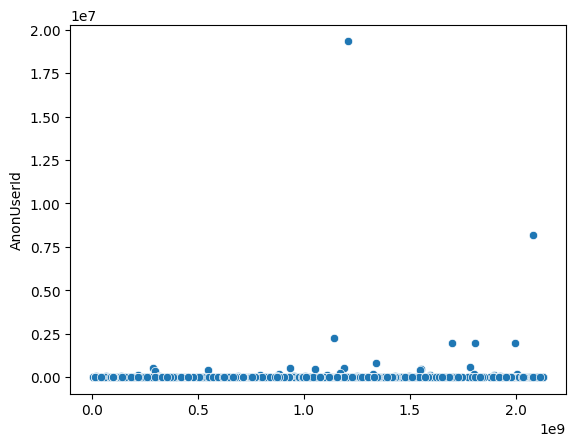

In [165]:
sns.scatterplot(data=df.AnonUserId.value_counts())

## Alphabetical distribution of blob names

In [166]:
letter_counts = []

for letter in alc:
    letter_counts.append(df[df['AnonBlobName'].str.startswith(letter)].AnonBlobName.unique().size)

<AxesSubplot: >

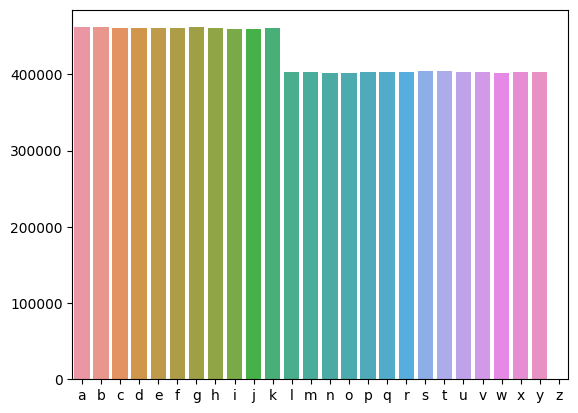

In [167]:
sns.barplot(x=[x for x in alc],y=letter_counts)

## Alphanumeric distribution of blob names 

In [168]:
buckets = {}

for filename in df.AnonBlobName.unique():
    indexed_bucket = filename[0:4]
    if indexed_bucket in buckets:
        buckets[indexed_bucket] += 1
    else:
        buckets[indexed_bucket] = 1

In [169]:
access_buckets = {}

for filename in df.AnonBlobName:
    indexed_bucket = filename[0:4]
    if indexed_bucket in access_buckets:
        access_buckets[indexed_bucket] += 1
    else:
        access_buckets[indexed_bucket] = 1

### Accesses per directory of files (DIRC/)

In [170]:
access_buckets

{'kk68': 228565,
 'q9ko': 482908,
 'm6iu': 13,
 'rrdp': 120725,
 '9wpj': 4339,
 'jfvf': 8097,
 'dfpq': 8084,
 'obkh': 18,
 'qo7r': 6107,
 'xw1k': 4843,
 'xfsn': 14,
 'p8pa': 646,
 'p86g': 13,
 '4dad': 1733,
 'q0wv': 59850,
 '6qhp': 17,
 'dd9n': 17,
 '77ff': 4048,
 '12ht': 10,
 'pnm4': 384269,
 'uc4j': 6721,
 'ahsd': 11,
 'idow': 3535,
 '9mis': 14,
 'v6k5': 19,
 'pgdj': 533797,
 'hig2': 20,
 '0qnx': 15,
 'u7s9': 12,
 'j3y1': 16,
 'vdoe': 12,
 'yktp': 14,
 'pi82': 13,
 '6y5g': 17,
 'qmxw': 21,
 '0y1h': 13,
 'jl66': 21,
 '87hg': 21,
 'l399': 9,
 '7x4s': 15,
 'snc7': 7411,
 '1422': 14,
 'ydbn': 27,
 'k6cg': 21,
 'vawd': 14,
 '7cdu': 17,
 'p0di': 13,
 'kt1i': 14,
 'hdhi': 18,
 'e78q': 790,
 '0t8w': 681,
 '1suu': 102,
 'ejmv': 18,
 'o4v4': 13,
 'ojsf': 17,
 'a0c2': 27,
 'bds4': 18,
 'a42n': 15,
 'echo': 164,
 'e8k7': 21,
 'm0g5': 12,
 '3ijx': 29,
 '5atk': 3928,
 'egl6': 16,
 'o6mw': 8312,
 'm4qe': 694,
 'be7y': 15,
 'dxtu': 688,
 'a94x': 15,
 'rqe1': 681,
 'gorc': 693,
 'ia80': 23,
 'jy19': 

### Files per directory (DIRC/)

In [171]:
buckets

{'kk68': 14,
 'q9ko': 6,
 'm6iu': 11,
 'rrdp': 11,
 '9wpj': 13,
 'jfvf': 13,
 'dfpq': 11,
 'obkh': 13,
 'qo7r': 9,
 'xw1k': 10,
 'xfsn': 11,
 'p8pa': 12,
 'p86g': 8,
 '4dad': 8,
 'q0wv': 11,
 '6qhp': 11,
 'dd9n': 10,
 '77ff': 10,
 '12ht': 6,
 'pnm4': 13,
 'uc4j': 21,
 'ahsd': 6,
 'idow': 8,
 '9mis': 11,
 'v6k5': 11,
 'pgdj': 14,
 'hig2': 12,
 '0qnx': 10,
 'u7s9': 8,
 'j3y1': 11,
 'vdoe': 7,
 'yktp': 7,
 'pi82': 10,
 '6y5g': 10,
 'qmxw': 12,
 '0y1h': 10,
 'jl66': 13,
 '87hg': 13,
 'l399': 4,
 '7x4s': 9,
 'snc7': 10,
 '1422': 11,
 'ydbn': 20,
 'k6cg': 15,
 'vawd': 8,
 '7cdu': 9,
 'p0di': 8,
 'kt1i': 10,
 'hdhi': 11,
 'e78q': 10,
 '0t8w': 3,
 '1suu': 13,
 'ejmv': 11,
 'o4v4': 7,
 'ojsf': 12,
 'a0c2': 15,
 'bds4': 10,
 'a42n': 8,
 'echo': 15,
 'e8k7': 17,
 'm0g5': 7,
 '3ijx': 11,
 '5atk': 16,
 'egl6': 11,
 'o6mw': 10,
 'm4qe': 15,
 'be7y': 12,
 'dxtu': 10,
 'a94x': 11,
 'rqe1': 7,
 'gorc': 12,
 'ia80': 17,
 'jy19': 15,
 'sdnk': 8,
 'klil': 9,
 '9kph': 13,
 '8nnd': 10,
 '97eg': 11,
 'xk4a':

### Average files per directory

In [172]:
avg_files_per_dir = sum(buckets.values()) / len(buckets)

In [173]:
avg_files_per_dir

9.823477232800975

### Example of a random bucket

In [174]:
df[df['AnonBlobName'].str.startswith("1wx5")].AnonBlobName.unique()

array(['1wx5xja9wlha4atv', '1wx52nba2uofeudo', '1wx5ilwseds1vhf7',
       '1wx5dgohq1kiwjum', '1wx53ji1ev0m8if6', '1wx55ye9v3w6igl6',
       '1wx56p8v72p1gy27', '1wx5cvpvl3wm187e'], dtype=object)

### Distribution of files per directory (visualized)

In [ ]:
keys = list(buckets.keys())
# get values in the same order as keys, and parse percentage values
vals = [buckets[k] for k in keys]
sns.barplot(x=keys, y=vals)

## Number of different files

In [177]:
df.AnonBlobName.unique().size

14740049

## Number of reads 

77% of the accesses within the 44 million entry trace are reads

In [178]:
len(df[df["Read"] == True])

34238962

In [179]:
len(df[df["Read"] == True]) * 100 / len(df)

77.31867768768232

## Types of blobs

In [180]:
for blob_type in df.BlobType.unique():
    print(blob_type)

BlockBlob/application/octet-stream
BlockBlob/
BlockBlob/text/plain; charset=utf-8
BlockBlob/application/json
BlockBlob/text/xml
BlockBlob/application/zip
BlockBlob/application/x-zip-compressed
BlockBlob/text/plain
BlockBlob/application/vnd.openxmlformats-officedocument.spreadsheetml.sheet
BlockBlob/application/vnd.ms-excel
BlockBlob/text/html
BlockBlob/image/jpeg
BlockBlob/image/png
BlockBlob/application/vnd.ms-excel.sheet.macroEnabled.12
BlockBlob/text/csv
BlockBlob/application/pdf
BlockBlob/text/xml;
BlockBlob/application/unknown
BlockBlob/text/markdown
BlockBlob/None
BlockBlob/application/json; charset=utf-8
BlockBlob/application/xml
BlockBlob/image/webp
BlockBlob/image/jpg
BlockBlob/image/gif
BlockBlob/image/vnd.microsoft.icon
AppendBlob/application/octet-stream
BlockBlob/text/xml; charset=utf-8
BlockBlob/application/x-msdownload
BlockBlob/text/csv; charset=utf-8
BlockBlob/application/octet-stream Charset=UTF-8
BlockBlob/plain/text
BlockBlob/text/tab-separated-values


# Trace emulation pre-processing

Since the trace represents a one month slice in the lifetime of a datacenter, it is expected that some files that are accessed within the trace have been written before the beginning timestamp of the trace. To avoid the emulator not finding the files, we export the files that at some point did not exist before a read and write those files first.

## Number of reads to files that have not been written yet

We find the files that have at some point not existed before a read and assign their size to the size of their largest read within the trace.

In [23]:
app_sample = pd.read_csv("12hour-traces/kla1jqcy-12hour.csv")

In [24]:
written_files = {}
not_yet_existing_files = {}
reads_to_non_existing = 0

blob_names = app_sample['AnonBlobName'].values
blob_bytes = app_sample['BlobBytes'].values
is_write = app_sample['Write'].values


for i in range(len(app_sample)):
    if is_write[i] == True:
        written_files[blob_names[i]] = blob_bytes[i]
    else:
        if blob_names[i] not in written_files.keys():
            if blob_names[i] not in not_yet_existing_files.keys():
                not_yet_existing_files[blob_names[i]] = blob_bytes[i]
            else:
                not_yet_existing_files[blob_names[i]] = max(not_yet_existing_files[blob_names[i]], 
                                                              blob_bytes[i])

In [25]:
np.sum(list(not_yet_existing_files.values())) + np.sum(list(written_files.values()))

8196475.0

In [1201]:
app_sample = trace_xlxky5ax

blob_bytes = app_sample['BlobBytes'].values
is_write = app_sample['Write'].values

write_bytes= 0
read_bytes = 0

for i in range(len(app_sample)):
    if is_write[i] == True:
        write_bytes += blob_bytes[i]
    else:
        read_bytes += blob_bytes[i]

        
print(read_bytes * 1e-9, write_bytes * 1e-9)

0.5618650030000001 0.5618688550000001


## Number of files that at some point, do not exist before a read

In [27]:
len(not_yet_existing_files.keys())

0

## Number of non existing files

In [185]:
non_existing_files = df.AnonBlobName.unique().size - len(written_files.keys())
print(non_existing_files)

9645447


## Number of files that are created within the trace

In [186]:
len(not_yet_existing_files.keys()) - non_existing_files

1619

## Writing missing files to a text file 

In [172]:
with open("12hour-traces/missing_files_7xjpt3h0_12hour.txt", "w+") as file:
    for key in not_yet_existing_files.keys():
        file.write("{} {}\n".format(key, not_yet_existing_files[key]))

## Creating missing files

In [45]:
app_name = sample.AnonAppName.unique()[0]

### DIRC/filename splitting

Distributing and indexing files in directories using the first 4 letters of the blob name

In [ ]:
missing_files = open("missing_files.txt", "r").readlines()

for filename in missing_files:
    DIRC = filename[0:4]
    name = DIRC + "/" + filename[4:-1]
    os.makedirs(os.path.dirname("DIRC/" + name), exist_ok=True)
    file = open("DIRC/" + name, "w")
    file.close()
    
missing_files.close()

### DIR/C/ filename splitting (optimal split)

Distributing and indexing files in directories first using the first 3 letters of the blob name and then the 4th letter for another directory layer. This results in a directory tree of depth 3 at most

In [ ]:
files = []
sizes = []

for line in open("missing_files.txt", "r"):
    splitted = line[:-1].split(" ")
    files.append(splitted[0])
    sizes.append(float(splitted[1]))

directories = {}

for index, filename in enumerate(files):
    root_dir = "serverlessfs/bench/trace-emulator/test_dir"
    DIR = filename[0:3]
    C = filename[3:4]
    path = filename[0:3] + "/" + filename[3:4]

    if DIR not in directories:
        directories[DIR] = {}
        directories[DIR][C] = 0
        os.mkdir(root_dir + "/" + DIR)
        os.mkdir(root_dir + "/" + path)
    elif C not in directories[DIR]:
        directories[DIR][C] = 0
        os.mkdir(root_dir +  "/" + path)

    name = path + "/" + filename[4:] 

    with open(root_dir + "/" + name, "w") as file:
        for i in range(int(sizes[index]) - 1):
            file.write("0");
        file.write("\n")

## SWIFT direct S3 API performance 

In [26]:
df_swift_direct = pd.read_csv("report_swift_direct.csv")

In [37]:
df_swift_direct[df_swift_direct["op"] == "write"][" duration_us"].median()

148552.5

In [38]:
df_swift_direct[df_swift_direct["op"] == "read"][" duration_us"].median()

43732.0

# Emulation report analysis

In [120]:
df_ceph = pd.read_csv("report_ceph.csv")

In [121]:
df_slsfs = pd.read_csv("report_slsfs.csv")

In [122]:
df_swift = pd.read_csv("report_swiftkv.csv")

In [123]:
df_slsfs_newproxy = pd.read_csv("report_ssbd_newproxy.csv")

In [124]:
df_ceph_nerc = pd.read_csv("report_ceph_nerc.csv")

In [125]:
df_drive_local = pd.read_csv("report_ssbd1_local.csv")

In [126]:
df_ssbd_mutex = pd.read_csv("report_ssbd_mutex.csv")

In [127]:
df_ssbd_stripe = pd.read_csv("report_ssbd_stripe_4k.csv")

In [128]:
df_ceph['bytes'] = df_ceph['bytes'].apply(lambda x: x * 0.001)
df_ceph = df_ceph.sort_values(by="bytes")

df_slsfs['bytes'] = df_slsfs['bytes'].apply(lambda x: x * 0.001)
df_slsfs = df_slsfs.sort_values(by="bytes")

df_swift['bytes'] = df_swift['bytes'].apply(lambda x: x * 0.001)
df_swift = df_swift.sort_values(by="bytes")

df_slsfs_newproxy['bytes'] = df_slsfs_newproxy['bytes'].apply(lambda x: x * 0.001)
df_slsfs_newproxy = df_slsfs_newproxy.sort_values(by="bytes")

df_ceph_nerc['bytes'] = df_ceph_nerc['bytes'].apply(lambda x: x * 0.001)
df_ceph_nerc = df_ceph_nerc.sort_values(by="bytes")

df_drive_local['bytes'] = df_drive_local['bytes'].apply(lambda x: x * 0.001)
df_drive_local = df_drive_local.sort_values(by="bytes")

df_ssbd_mutex['bytes'] = df_ssbd_mutex['bytes'].apply(lambda x: x * 0.001)
df_ssbd_mutex = df_ssbd_mutex.sort_values(by="bytes")

df_ssbd_stripe['bytes'] = df_ssbd_stripe['bytes'].apply(lambda x: x * 0.001)
df_ssbd_stripe = df_ssbd_stripe.sort_values(by="bytes")

## SLSFS SSBD STRIPE 4K block READ

(0.0, 40.0)

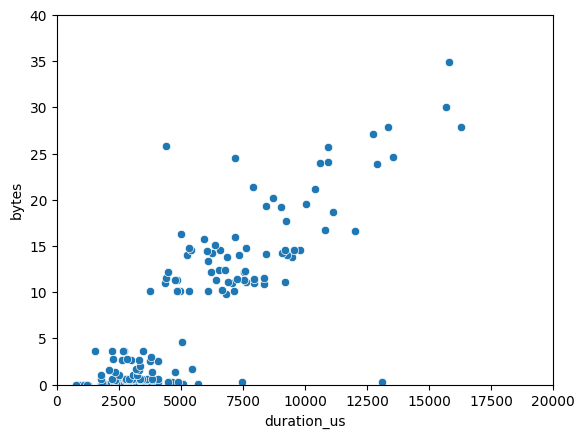

In [158]:
ax = sns.scatterplot(data=df_ssbd_stripe[df_ssbd_stripe["access_type"] == " read"], x=df_ssbd_stripe[df_ssbd_stripe["access_type"] == " read"].duration_us, y = df_ssbd_stripe[df_ssbd_stripe["access_type"] == " read"].bytes)
ax.set_xlim(0,20000)
ax.set_ylim(0,40)

## SLSFS SSBD STRIPE 4K block WRITE

(0.0, 20.0)

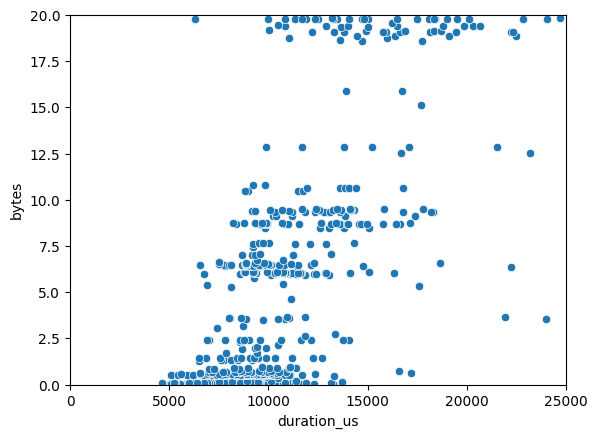

In [156]:
ax = sns.scatterplot(data=df_ssbd_stripe[df_ssbd_stripe["access_type"] == " write"], x=df_ssbd_stripe[df_ssbd_stripe["access_type"] == " write"].duration_us, y = df_ssbd_stripe[df_ssbd_stripe["access_type"] == " write"].bytes)
ax.set_xlim(0,25000)
ax.set_ylim(0,20)

## SLSFS 1 SSBD MUTEX READ

(0.0, 5000.0)

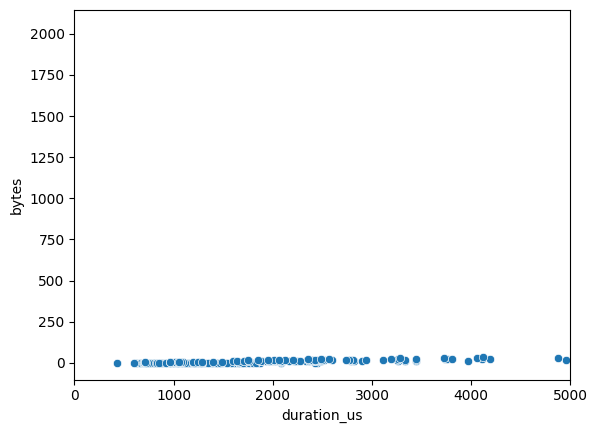

In [157]:
ax = sns.scatterplot(data=df_ssbd_mutex[df_ssbd_mutex["access_type"] == " read"], x=df_ssbd_mutex[df_ssbd_mutex["access_type"] == " read"].duration_us, y = df_ssbd_mutex[df_ssbd_mutex["access_type"] == " read"].bytes)
ax.set_xlim(0,5000)
ax.set_xlim(0,5000)

## SLSFS 1 SSBD MUTEX WRITE

## CEPH FS NERC READ

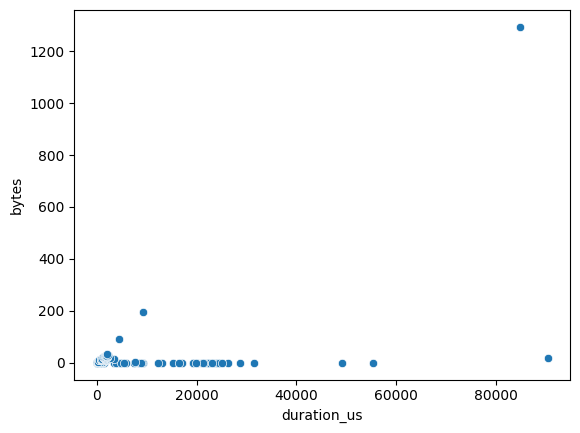

In [78]:
ax = sns.scatterplot(data=df_ceph_nerc[df_ceph_nerc["access_type"] == " read"], x=df_ceph_nerc[df_ceph_nerc["access_type"] == " read"].duration_us, y = df_ceph_nerc[df_ceph_nerc["access_type"] == " read"].bytes)

## CEPH FS NERC WRITE

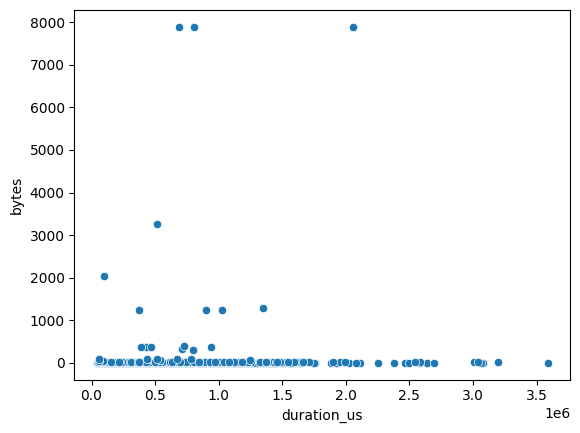

In [77]:
ax = sns.scatterplot(data=df_ceph_nerc[df_ceph_nerc["access_type"] == " write"], x=df_ceph_nerc[df_ceph_nerc["access_type"] == " write"].duration_us, y = df_ceph_nerc[df_ceph_nerc["access_type"] == " write"].bytes)

## NERC LOCAL SSBD 1 READ drive speed

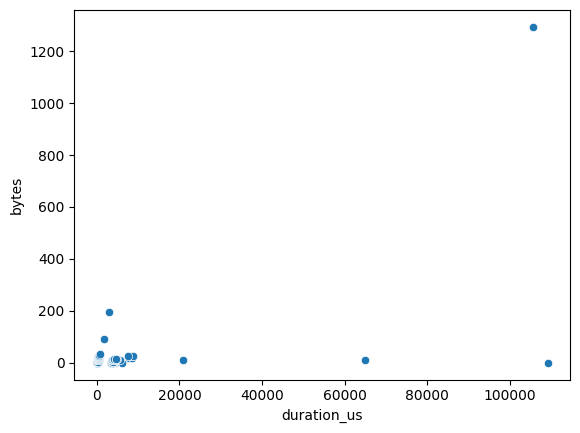

In [75]:
ax = sns.scatterplot(data=df_drive_local[df_drive_local["access_type"] == " read"], x=df_drive_local[df_drive_local["access_type"] == " read"].duration_us, y = df_drive_local[df_drive_local["access_type"] == " read"].bytes)

## NERC LOCAL SSBD 1 WRITE drive speed

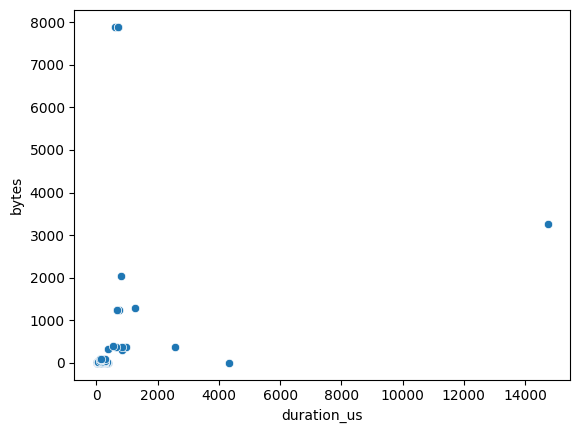

In [76]:
ax = sns.scatterplot(data=df_drive_local[df_drive_local["access_type"] == " write"], x=df_drive_local[df_drive_local["access_type"] == " write"].duration_us, y = df_drive_local[df_drive_local["access_type"] == " write"].bytes)

## CEPH FS

(0.0, 10000.0)

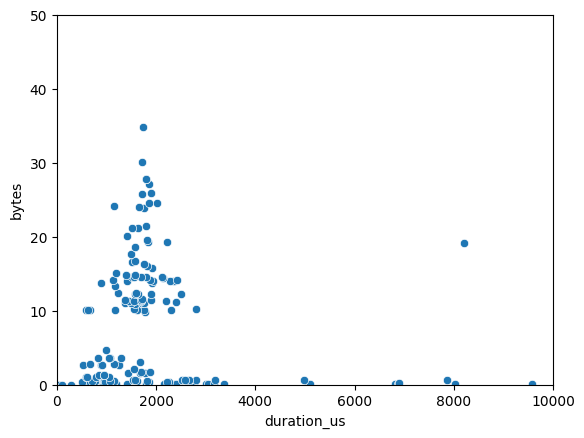

In [138]:
ax = sns.scatterplot(data=df_ceph[df_ceph["access_type"] == " read"], x=df_ceph[df_ceph["access_type"] == " read"].duration_us, y = df_ceph[df_ceph["access_type"] == " read"].bytes)
ax.set_ylim(0,50)
ax.set_xlim(0,10000)

## SLSFS (SSBD)

/var/folders/62/smvlkkzn71g5jmqvhj23jn_w0000gn/T/ipykernel_27187/91695490.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ax = sns.scatterplot(data=df_slsfs[df_slsfs["access_type"] == " read"][df_slsfs["bytes"] < 100], x=df_slsfs.duration_us, y = df_slsfs.bytes, hue='bytes')


(0.0, 10000.0)

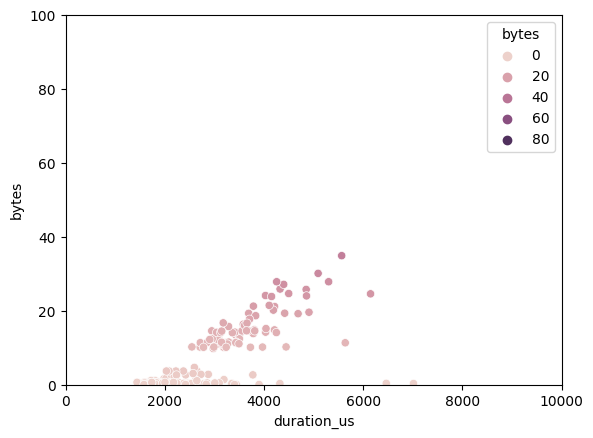

In [23]:
ax = sns.scatterplot(data=df_slsfs[df_slsfs["access_type"] == " read"][df_slsfs["bytes"] < 100], x=df_slsfs.duration_us, y = df_slsfs.bytes, hue='bytes')
ax.set_ylim(0,100)
ax.set_xlim(0,10000)

## SLSFS (SWIFT)

/var/folders/62/smvlkkzn71g5jmqvhj23jn_w0000gn/T/ipykernel_27187/76902825.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ax = sns.scatterplot(data=df_swift[df_swift["access_type"] == " read"][df_slsfs["bytes"] < 100], x=df_swift.duration_us, y = df_swift.bytes, hue='bytes')


(0.0, 100000.0)

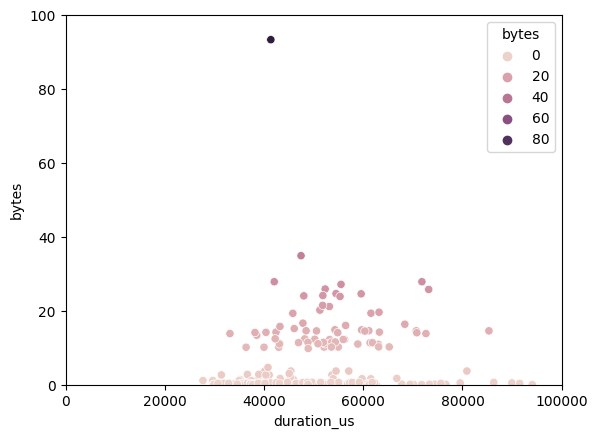

In [24]:
ax = sns.scatterplot(data=df_swift[df_swift["access_type"] == " read"][df_slsfs["bytes"] < 100], x=df_swift.duration_us, y = df_swift.bytes, hue='bytes')
ax.set_ylim(0,100)
ax.set_xlim(0,100000)

## SLSFS (SSBD-newproxy)

/var/folders/62/smvlkkzn71g5jmqvhj23jn_w0000gn/T/ipykernel_27187/4149454399.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ax = sns.scatterplot(data=df_slsfs_newproxy[df_slsfs_newproxy["access_type"] == " read"][df_slsfs["bytes"] < 100], x=df_slsfs_newproxy.duration_us, y = df_slsfs_newproxy.bytes, hue='bytes')


(0.0, 10000.0)

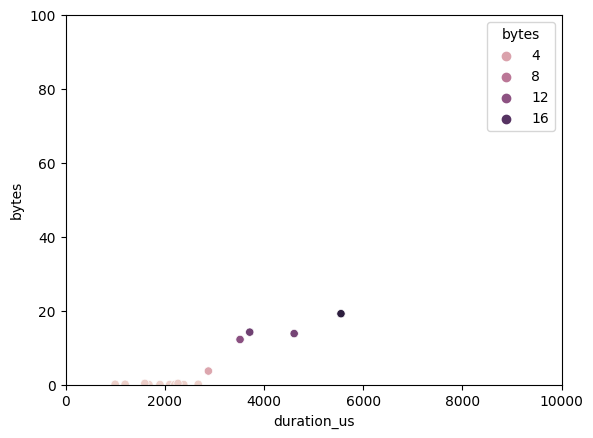

In [46]:
ax = sns.scatterplot(data=df_slsfs_newproxy[df_slsfs_newproxy["access_type"] == " read"][df_slsfs["bytes"] < 100], x=df_slsfs_newproxy.duration_us, y = df_slsfs_newproxy.bytes, hue='bytes')
ax.set_ylim(0,100)
ax.set_xlim(0,10000)

## CEPHFS

(0.0, 20000.0)

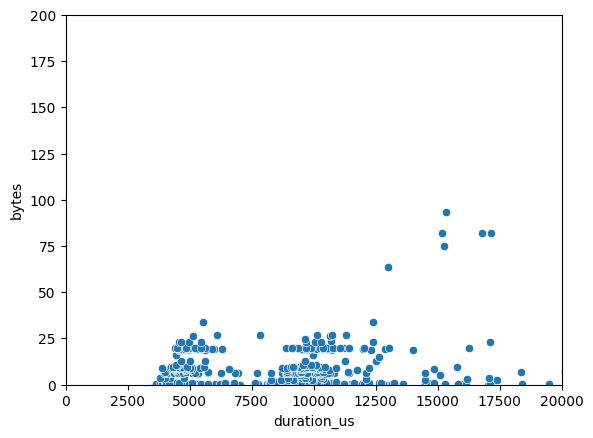

In [141]:
ax = sns.scatterplot(data=df_ceph[df_ceph["access_type"] == " write"], x=df_ceph[df_ceph["access_type"] == " write"].duration_us, y = df_ceph[df_ceph["access_type"] == " write"].bytes)
ax.set_ylim(0,200)
ax.set_xlim(0,20000)

## SLSFS (SSBD)

/var/folders/62/smvlkkzn71g5jmqvhj23jn_w0000gn/T/ipykernel_92628/1591763800.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ax = sns.scatterplot(data=df_slsfs[df_slsfs["access_type"] == " write"][df_slsfs["bytes"] < 1000], x=df_slsfs.duration_us, y = df_slsfs.bytes, hue='bytes')


(0.0, 20000.0)

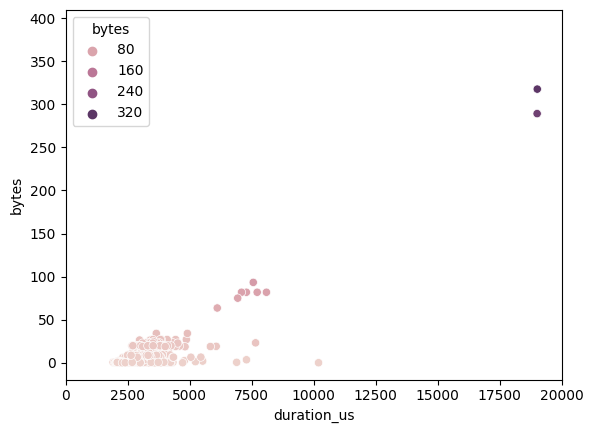

In [193]:
ax = sns.scatterplot(data=df_slsfs[df_slsfs["access_type"] == " write"][df_slsfs["bytes"] < 1000], x=df_slsfs.duration_us, y = df_slsfs.bytes, hue='bytes')
ax.set_xlim(0,20000)

## SLSFS (SWIFT)

/var/folders/62/smvlkkzn71g5jmqvhj23jn_w0000gn/T/ipykernel_27187/2834516813.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ax = sns.scatterplot(data=df_swift[df_swift["access_type"] == " write"][df_slsfs["bytes"] < 100], x=df_swift.duration_us, y = df_swift.bytes, hue='bytes')


(0.0, 100.0)

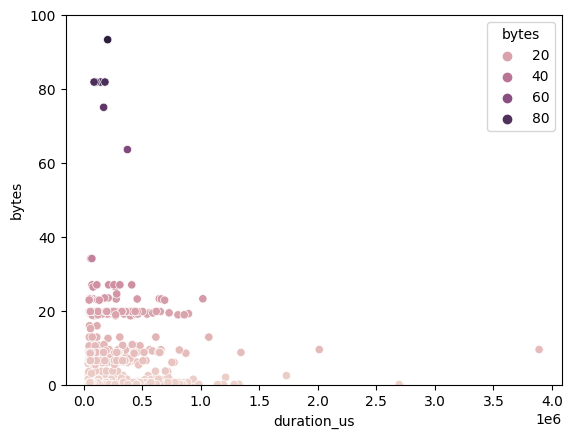

In [48]:
ax = sns.scatterplot(data=df_swift[df_swift["access_type"] == " write"][df_slsfs["bytes"] < 100], x=df_swift.duration_us, y = df_swift.bytes, hue='bytes')
ax.set_ylim(0,100)
ax.set_xlim(0,100000)

## SLSFS (SSBD-newproxy)

/var/folders/62/smvlkkzn71g5jmqvhj23jn_w0000gn/T/ipykernel_27187/185467879.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ax = sns.scatterplot(data=df_slsfs_newproxy[df_slsfs_newproxy["access_type"] == " write"][df_slsfs["bytes"] < 100], x=df_slsfs_newproxy.duration_us, y = df_slsfs_newproxy.bytes, hue='bytes')


(0.0, 10000.0)

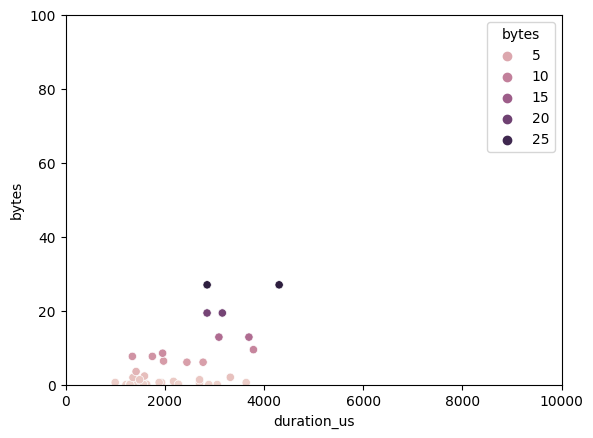

In [47]:
ax = sns.scatterplot(data=df_slsfs_newproxy[df_slsfs_newproxy["access_type"] == " write"][df_slsfs["bytes"] < 100], x=df_slsfs_newproxy.duration_us, y = df_slsfs_newproxy.bytes, hue='bytes')
ax.set_ylim(0,100)
ax.set_xlim(0,10000)